## Config

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import os
import math
import time
import sys
sys.path.append('..')

from source.utils import split_run_results

# use colorblind color palette 
plt.style.use('tableau-colorblind10')


In [120]:
'''
    USER INPUT
'''

DO_SAVE = True
#run_names = ['resnet101_pr50_lcm0.0001_batch16', 'resnet101_pr75_lcm0.0001_batch16', 'resnet101_pr85_lcm0.0001_batch16'] # these logs dont have rx ip and port yet 
#run_names = ['resnet18_pr50_lcm0.0001_batch64', 'resnet18_pr75_lcm0.0001_batch64', 'resnet18_pr85_lcm0.0001_batch64'] # these logs dont have rx ip and port yet
#run_names = [ 'filter']
run_names = ['cifar100-resnet101-run1.1', 'cifar100-resnet101-kernel-np4-pr0.85-lcm1e-05-run1']
num_runs = len(run_names)
test_name = run_names[0]
log_name = 'resnet101'
num_nodes = 4

save_dir = os.path.join('./assets_demo_2', 'figs', test_name)
log_file_path = os.path.join('./demo_logs', test_name)

if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [121]:
block_event_df, layer_event_df, total_runtime = split_run_results.combine_log_files(log_file_path, log_name, num_nodes)

In [122]:
''' 
    Make block event timeline plot
'''
#block_event_df[block_event_df['node'] == 0][['type', 'timestamp','time','dur', 'type']].head(7)
block_event_df


,timestamp,time,node,layer,layer_name,type,dur,process_dur,bytes_tx,serialize_dur,encode_dur_tx,ip,port,bytes_rx,deserialize_time
496,2024-10-16 02:04:03.954297275,0.000000,1,0,NaN,receive,1.702725,NaN,NaN,NaN,NaN,NaN,NaN,36.0,0.031560
72,2024-10-16 02:04:03.956305735,2.008460,1,1,conv1,execute,5.694265,0.001303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2024-10-16 02:04:03.957000000,2.702725,1,0,NaN,idle,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,2024-10-16 02:04:03.962213818,7.916543,1,1,NaN,total_send,12.786182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,2024-10-16 02:04:03.962842539,8.545264,1,1,NaN,prep,0.157461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2024-10-16 02:04:08.175824092,4221.526817,3,244,NaN,send,4.175908,NaN,9048.0,0.133914,0.001328,172.30.198.199,49200.0,NaN,NaN
347,2024-10-16 02:04:08.176529001,4222.231726,0,244,NaN,send,4.470999,NaN,9048.0,0.128706,0.001456,172.30.198.199,49200.0,NaN,NaN
707,2024-10-16 02:04:08.176753597,4222.456322,1,244,NaN,receive,2.246403,NaN,NaN,NaN,NaN,NaN,NaN,9048.0,0.129598
143,2024-10-16 02:04:08.179892242,4225.594967,1,245,FINAL_MODEL_OUTPUT,execute,118.107758,0.182562,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# Get maximum time
max_time_runs = 0
for irun in range(num_runs):
    run_name = run_names[irun]
    run_df = split_run_results.combine_log_files(os.path.join('demo_logs', run_name), log_name, num_nodes)[0]
    df_max_time = (run_df['time'] + run_df['dur']).max()
    if df_max_time > max_time_runs:
        max_time_runs = df_max_time
print(max_time_runs)

4343.7027245311065


## Plots Sandbox

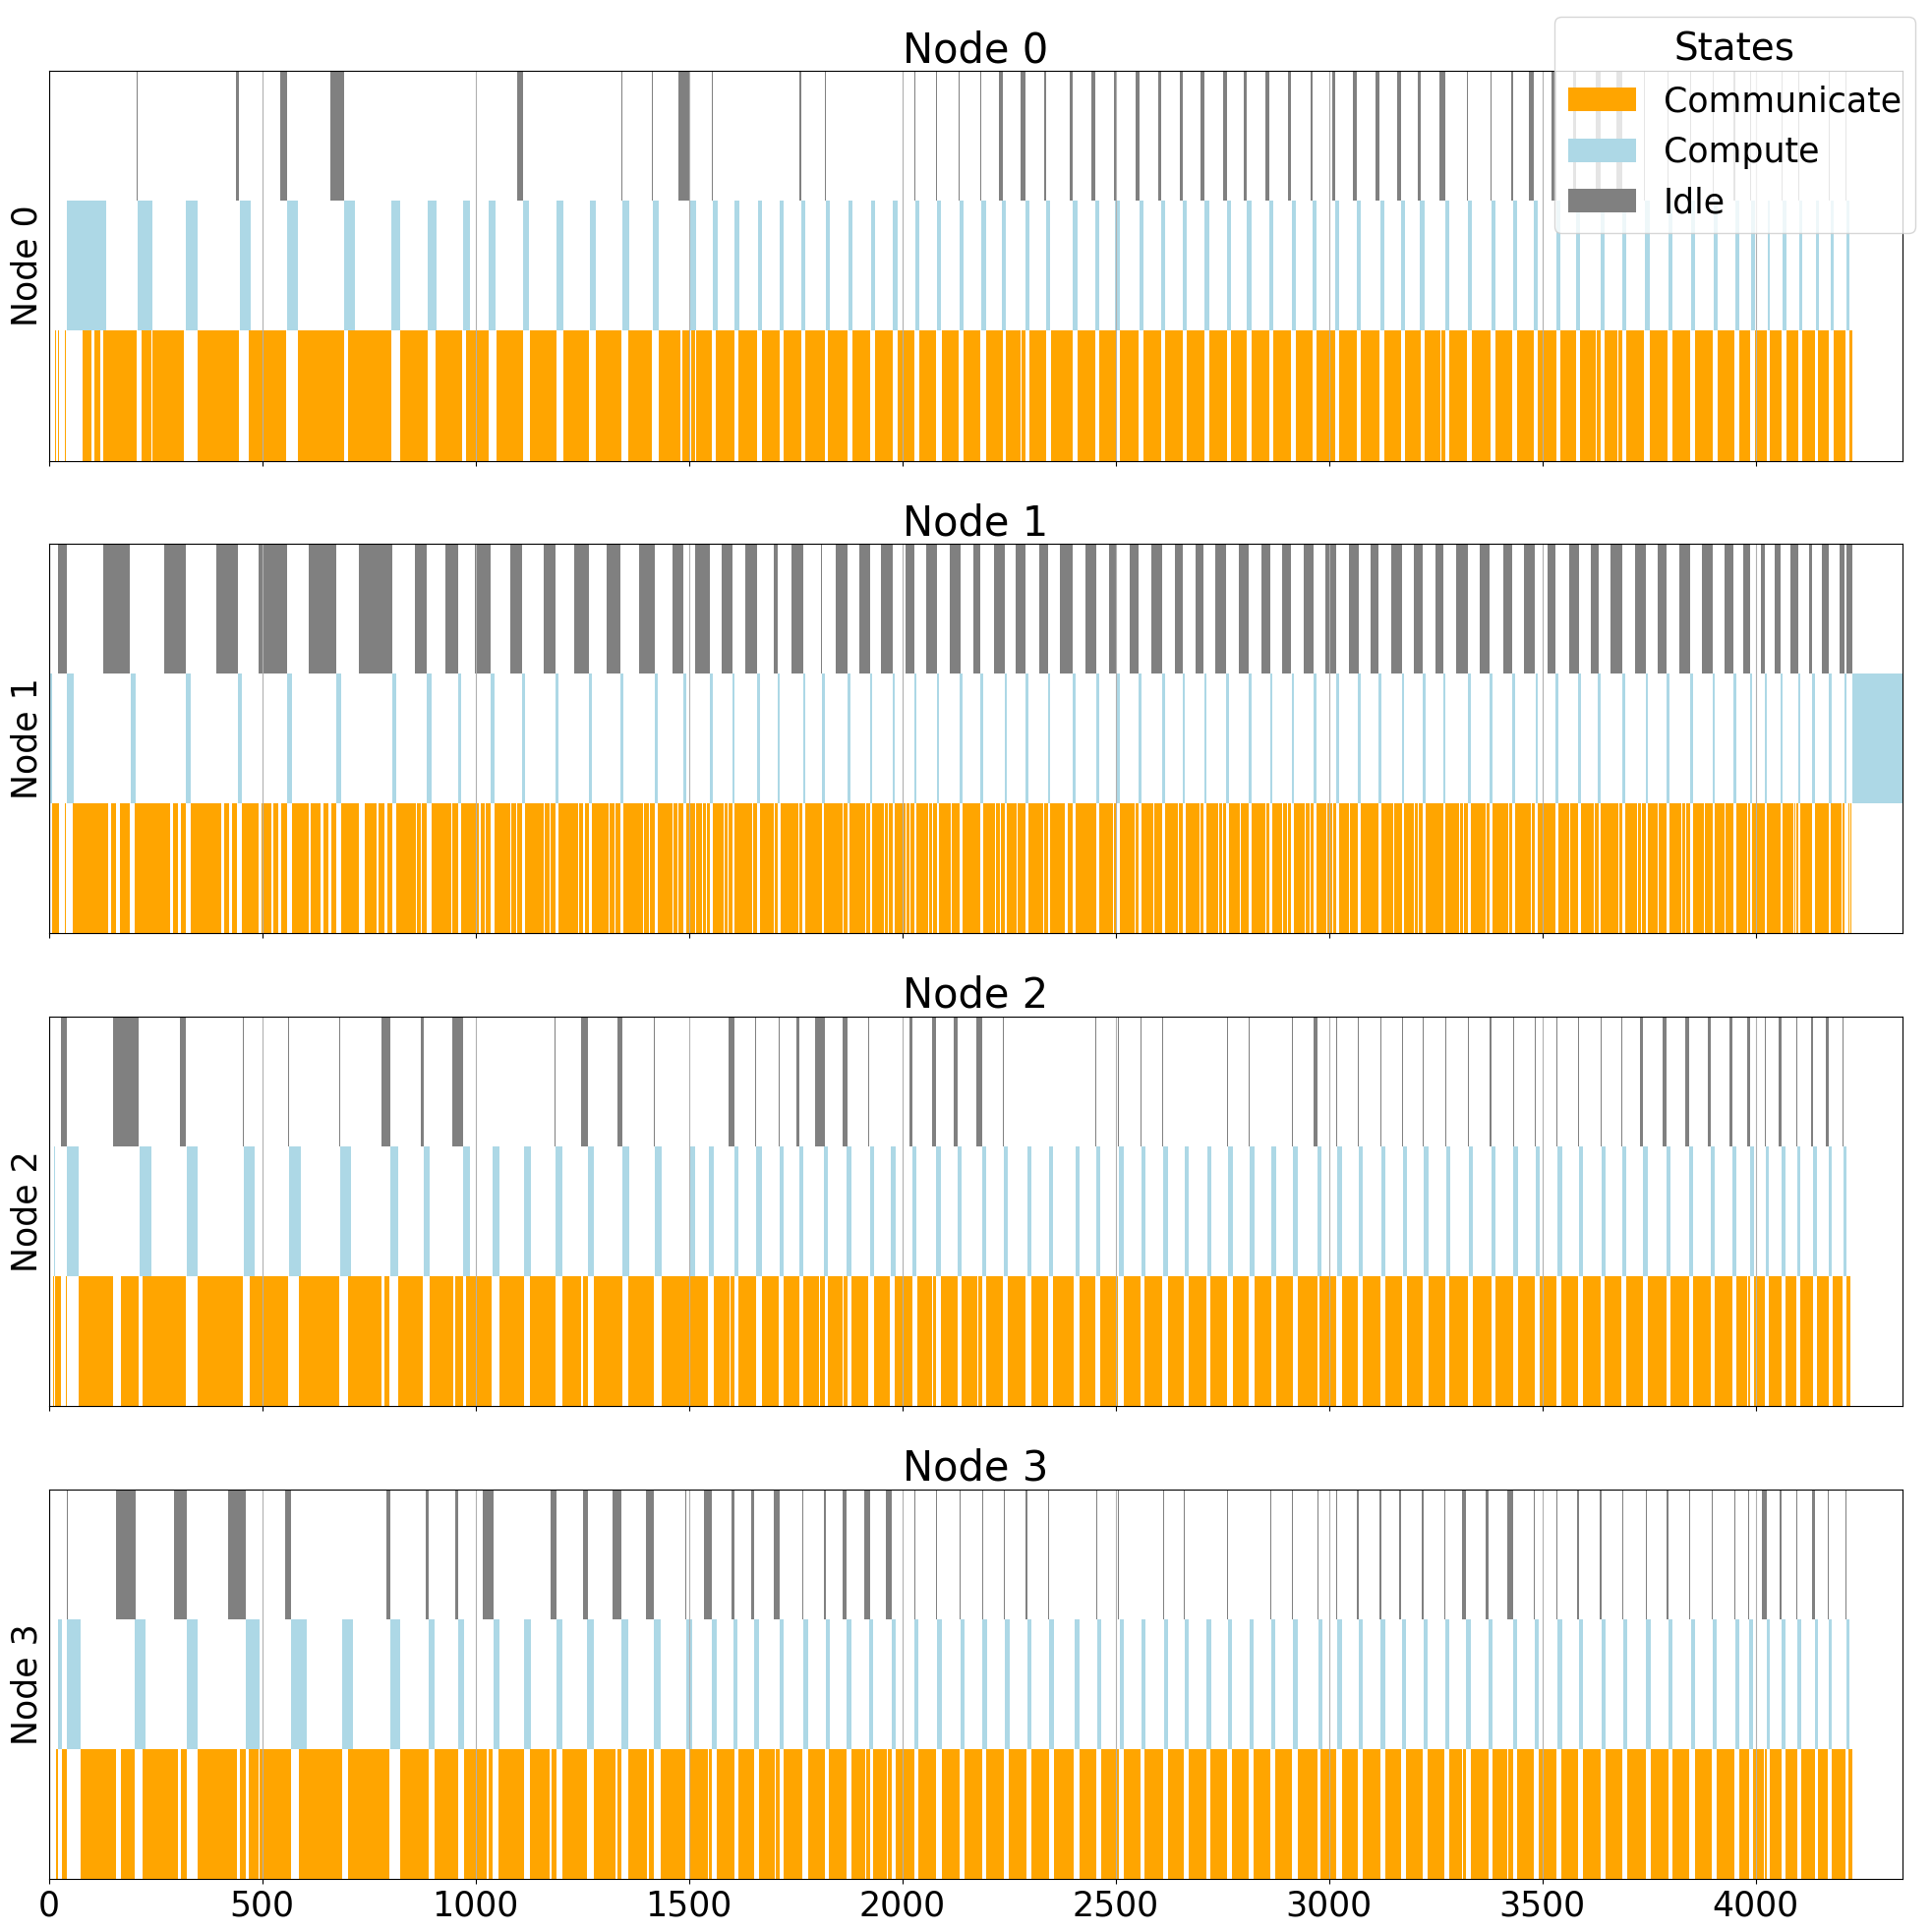

In [75]:
def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# Define parameters
yheight = 1
ystep = 1

# Replace 'num_nodes' with the actual number of nodes in your data
num_nodes = block_event_df['node'].nunique()
comms_width = yheight / num_nodes

# Merge 'receive', 'prep', and 'total_send' into 'Communicate'
state_types = ['Communicate', 'Compute', 'Idle']
state_type_positions = {state: idx for idx, state in enumerate(state_types)}
state_colors = {
    'Communicate': 'orange',  # Color for 'Communicate' state
    'Compute': 'lightblue',
    'Idle': 'gray',
}

num_states = len(state_types)
max_time = (block_event_df['time'] + block_event_df['dur']).max()

# Preprocess data for static plot
plot_data = {}  # Dictionary to store data for each node and state
for inode in range(num_nodes):
    plot_data[inode] = {}
    node_df = block_event_df[block_event_df['node'] == inode]

    # Combine 'receive', 'prep', and 'total_send' into 'Communicate'
    communicate_df = node_df[node_df['type'].isin(['receive', 'prep', 'total_send'])]
    communicate_bars = seq_of_tuples(communicate_df, 'time', 'dur')
    plot_data[inode]['Communicate'] = communicate_bars

    # Process 'Execute' and 'Idle' states
    for state in ['Execute', 'Idle']:
        df_state = node_df[node_df['type'] == state.lower()]
        bars = seq_of_tuples(df_state, 'time', 'dur')
        if state == 'Execute':
            plot_data[inode]['Compute'] = bars
        else:
            plot_data[inode][state] = bars

# Set up the figure and axes with increased font sizes
plt.rcParams.update({'font.size': 25})  # Increase the global font size

fig, axs = plt.subplots(num_nodes, 1, figsize=(20, 20), sharex=True)

# Create legend entries with increased font size
legend_patches = []
for state in state_types:
    patch = Patch(facecolor=state_colors[state], label=state)
    legend_patches.append(patch)

# Add the legend to the figure (only once)
fig.legend(handles=legend_patches, loc='upper right', title='States', fontsize=25, title_fontsize=28)

# Plot all nodes in a static plot
for inode in range(num_nodes):
    ax = axs[inode]

    # Set labels and limits
    ax.set_ylabel(f'Node {inode}')
    ax.set_yticks([])
    ax.set_xlim(0, max_time_runs)
    ax.set_ylim(0, num_states * ystep)  # Adjusted ylim to start from 0
    ax.grid(True, axis='x')  # Add vertical grid only

    # Plot the bars for each state
    for istate, state in enumerate(state_types):
        bars = plot_data[inode][state]
        for bar in bars:
            start_time, duration = bar
            end_time = start_time + duration
            rect = patches.Rectangle(
                (start_time, ystep * istate),
                duration,
                yheight,
                facecolor=state_colors[state],
                edgecolor='none'
            )
            ax.add_patch(rect)

    # Set title for each node
    ax.set_title(f'Node {inode}')

plt.tight_layout()
plt.show()

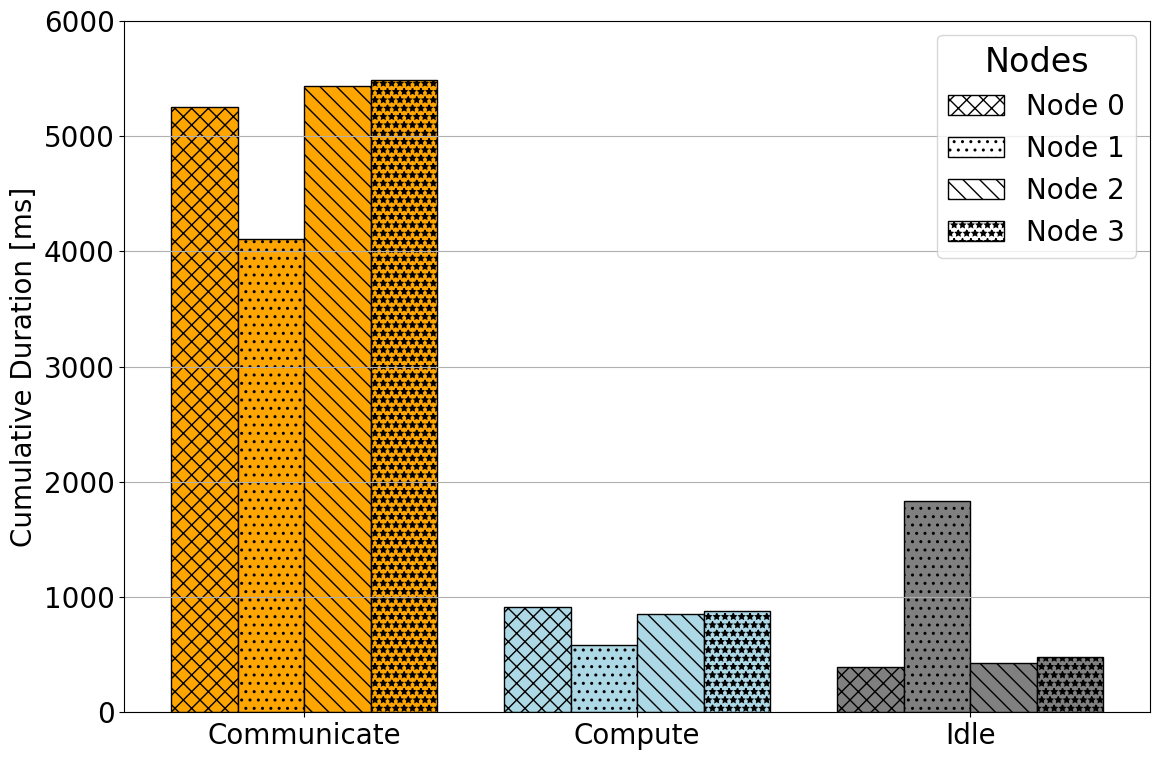

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os

# Assume 'data_frame' is your DataFrame for one run
# It should have columns: 'node', 'type', 'time', 'dur'
# Also assume 'max_time' is defined (maximum end time of events)
data_frame = block_event_df  # Replace with your actual DataFrame

# Define new stages and nodes
stages = ['Communicate', 'Execute', 'Idle']  # Changed 'Execute' to 'Compute'
num_stages = len(stages)
num_nodes = data_frame['node'].nunique()  # Get the number of nodes from the data

# Define colors and hatches
stage_colors = ['orange', 'lightblue', 'gray']  # Colors for the stages
hatch_list = ["xx", "..", "\\\\", "**"]  # Hatches for the nodes

# Map for the original types to new stages
type_to_stage = {
    'total_send': 'Communicate',
    'receive': 'Communicate',
    'execute': 'Compute',  # Changed 'Execute' to 'Compute'
    'idle': 'Idle'
}

# Calculate max_time if not already defined
if 'max_time' not in locals():
    data_frame['end_time'] = data_frame['time'] + data_frame['dur']
    max_time = data_frame['end_time'].max()

# Initialize cumulative_durations array
# Shape: (num_nodes, num_stages)
cumulative_durations = np.zeros((num_nodes, num_stages))

# Compute cumulative durations for each node and stage
for node in range(num_nodes):
    node_df = data_frame[data_frame['node'] == node]
    for stage_idx, stage in enumerate(stages):
        if stage == 'Communicate':
            # Include both 'total_send' and 'receive' events
            events = node_df[node_df['type'].isin(['total_send', 'receive'])]
        else:
            # For other stages, select events where type matches the stage name (case-insensitive)
            events = node_df[node_df['type'].str.lower() == stage.lower()]
        # Sum the durations for the events
        total_duration = events['dur'].sum()
        cumulative_durations[node, stage_idx] = total_duration

# Initialize the figure and axes with larger font sizes
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(12, 8))

x_positions = np.arange(num_stages)  # Positions for stages
bar_width = 0.8 / num_nodes  # Bar width per node

# Plot the bars and store them in a dictionary
bars = {}  # bars[node][stage_idx] = bar

for node in range(num_nodes):
    x = x_positions + (node - (num_nodes - 1)/2) * bar_width
    node_bars = []
    for stage_idx, stage in enumerate(stages):
        height = cumulative_durations[node, stage_idx]
        bar = ax.bar(
            x[stage_idx],
            height,
            width=bar_width,
            color=stage_colors[stage_idx],
            hatch=hatch_list[node],
            edgecolor='black'
        )
        node_bars.append(bar[0])  # bar() returns a container; get the Bar object
    bars[node] = node_bars

# Set labels and title
ax.set_xticks(x_positions)
stages[1] = 'Compute'
ax.set_xticklabels(stages)
#ax.set_xlabel('Stages')
ax.set_ylabel('Cumulative Duration [ms]')
ax.set_ylim([0, 6000])  # Set y-limit slightly above the max duration
#ax.set_title('Cumulative Stage Durations')
ax.grid(True, axis='y')  # Add horizontal grid lines

# Create custom legend entries
# Legend for nodes (hatches)
node_patches = [
    Patch(facecolor='white', edgecolor='black', hatch=hatch_list[node], label=f'Node {node}')
    for node in range(num_nodes)
]

# Legend for stages (colors)
stage_patches = [
    Patch(facecolor=stage_colors[stage_idx], edgecolor='black', label=stage)
    for stage_idx, stage in enumerate(stages)
]

# Add legends to the plot with larger font sizes
#legend1 = ax.legend(handles=stage_patches, title='Stages', loc='upper left', fontsize=18, title_fontsize=20)
legend2 = ax.legend(handles=node_patches, title='Nodes', loc='upper right', fontsize=20, title_fontsize=24)
#ax.add_artist(legend1)  # Add the first legend back to the axes

plt.tight_layout()

# Save the static plot if needed
DO_SAVE = True  # Set to True if you want to save the plot

if DO_SAVE:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'cumulative_stage_durations.pdf'), transparent=True, bbox_inches='tight')
    
plt.show()


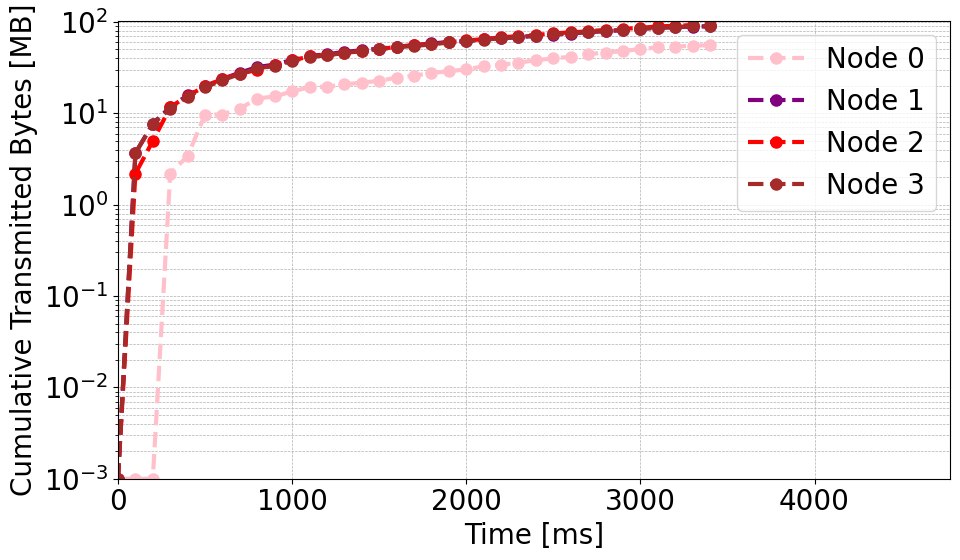

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Assuming 'block_event_df' is your DataFrame with columns: 'time', 'bytes_tx', 'node', 'type'

# Placeholder for demonstration; replace with your actual DataFrame
# block_event_df = pd.read_csv('your_data.csv')  # Uncomment and modify as needed

dense_max_bytes = 92873702  # Replace with your actual maximum bytes if different

# Parameters
colors = ['pink', 'purple', 'red', 'brown']
num_nodes = block_event_df['node'].nunique()
dt = 100  # Time step in milliseconds
max_time = block_event_df['time'].max()
time_steps = np.arange(0, max_time + dt, dt)

# Increase global font size
plt.rcParams.update({'font.size': 20})

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set y-scale to logarithmic
ax.set_yscale('log')

# Set labels and title
#ax.set_title('Cumulative Transmitted Bytes Over Time')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Cumulative Transmitted Bytes [MB]')

# Set limits
ax.set_xlim(0, max_time_runs * 1.1)
ax.set_ylim(1e-3, dense_max_bytes / 1e6 * 1.1)  # Start y-axis from a small positive value

# Add grid lines
ax.grid(True, which="both", ls="--", linewidth=0.5)

# Plot data for each node
for i in range(num_nodes):
    # Filter data for the node where 'type' is 'send' and 'bytes_tx' is not null
    df_node = block_event_df[
        (block_event_df['node'] == i) &
        (block_event_df['type'] == 'send') &
        (block_event_df['bytes_tx'].notna())
    ].sort_values('time').reset_index(drop=True)

    if not df_node.empty:
        # Interpolate cumulative bytes at each time step
        df_node['cum_bytes'] = df_node['bytes_tx'].cumsum()
        # Create an interpolation function
        from scipy.interpolate import interp1d

        interp_func = interp1d(
            df_node['time'],
            df_node['cum_bytes'],
            kind='previous',
            bounds_error=False,
            fill_value=(0, df_node['cum_bytes'].iloc[-1])
        )

        # Evaluate cumulative bytes at each time step
        cum_bytes_time_steps = interp_func(time_steps)
        # Convert to MB and ensure values are positive
        cum_bytes_time_steps = np.maximum(cum_bytes_time_steps / 1e6, 1e-3)

        # Plot with points every few milliseconds
        ax.plot(time_steps, cum_bytes_time_steps, '--o', label=f'Node {i}', color=colors[i], markersize=8, linewidth=3)
    else:
        # If no data for the node, plot a single point at (0, 1e-3)
        ax.plot(0, 1e-3, '--o', label=f'Node {i}', color=colors[i], markersize=4)

# Add legend with increased font size
ax.legend(fontsize=20, title_fontsize=24)

plt.tight_layout()

# Save the plot if needed
DO_SAVE = True  # Set to True if you want to save the plot

if DO_SAVE:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'cumulative_transmitted_bytes_logscale_with_points.pdf'), bbox_inches='tight')
    
plt.show()


In [26]:
cumulative_durations.max() * 1.1

6041.092444118113

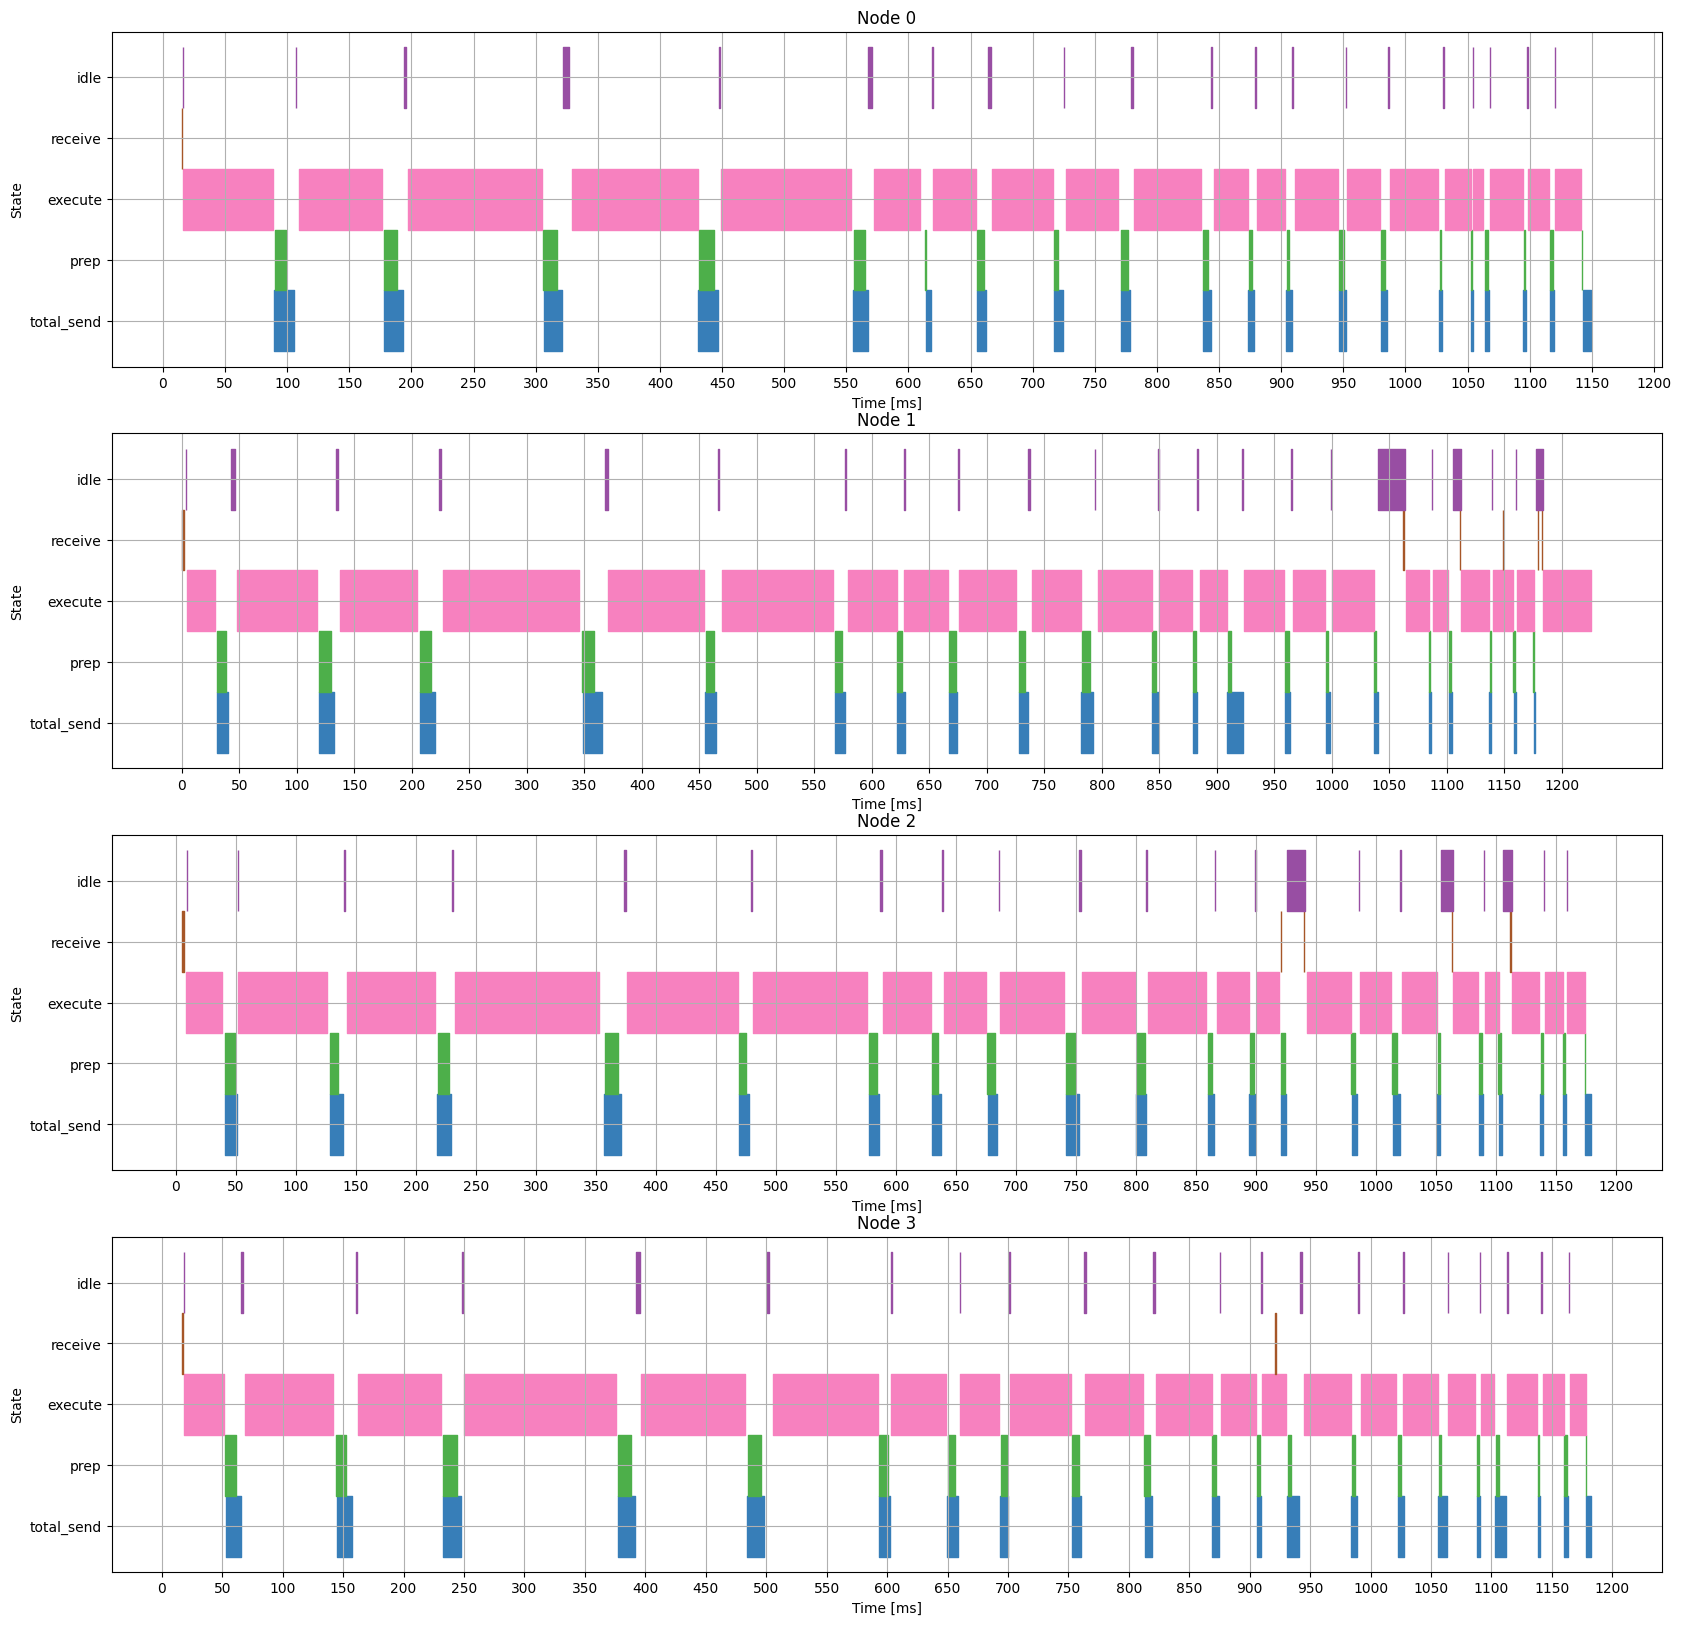

In [80]:
'''
    Plot timeline 
'''

def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# get layers that wait on inputs 
begin_block_layers = np.unique(block_event_df['layer'].to_numpy())

yheigth = 1
ystep = 1

comms_width = yheigth/num_nodes

fig, axs = plt.subplots(num_nodes, 1)
fig.set_size_inches(20,20)

# TODO: do for each node
inode = 0
state_types = ['total_send', 'prep','execute', 'receive', 'idle']
CB_color_cycle = ['#377eb8', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
num_states = len(state_types)

for inode in range(num_nodes):
    axs[inode].grid()
    for istate in range(num_states):

        state_type = state_types[istate]

        # format data and plot
        bars = seq_of_tuples(block_event_df.loc[(block_event_df['node'] == inode) & (block_event_df['type'] == state_type)], 'time', 'dur')
        axs[inode].broken_barh(bars, (ystep*istate - yheigth/2,yheigth), color=CB_color_cycle[istate])


    title_str = f'Node {inode}'
    axs[inode].set_title(title_str)
    axs[inode].set_xlabel('Time [ms]')
    axs[inode].set_ylabel('State')
    axs[inode].set_yticks(ticks=range(0, num_states*ystep, ystep), labels=state_types)

    xlim_range = []#[0, 200] #[700, 800]
    step_size = 50

    if [] == xlim_range:
        axs[inode].set_xticks(range(0, math.ceil(max(total_runtime)*1e3), step_size))
    else:
        axs[inode].set_xlim(xlim_range)
        axs[inode].set_xticks(range(xlim_range[0], xlim_range[1], step_size))
    
    #plt.legend(state_types)
    #plt.xlim(0,max(total_runtime)*1.1)

#fig.show()
#plt.ion()
#_ = plt.show()
    

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'block_execution_time.jpg'))




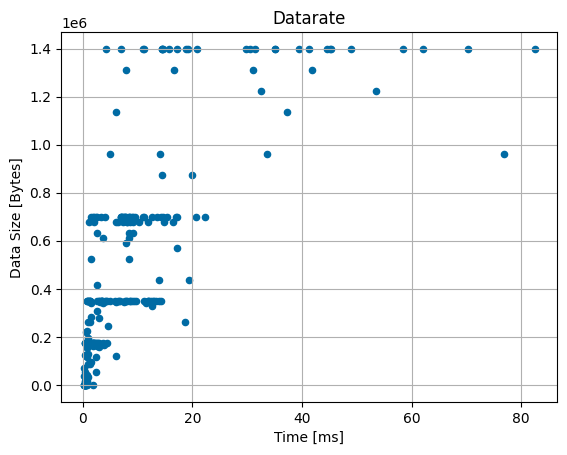

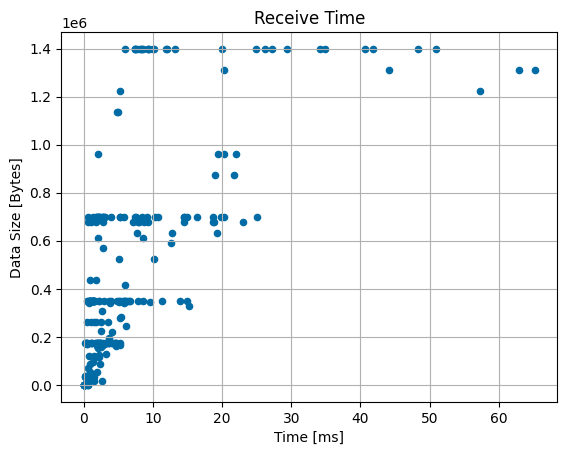

In [6]:
'''
    Make scatter plots for TX and RX
'''

ax_send = block_event_df[block_event_df['type'] == 'send'].plot.scatter(x='dur', y='bytes_tx')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = block_event_df[block_event_df['type'] == 'receive'].plot.scatter(x='dur', y='bytes_rx')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




In [7]:
'''
    Breakdown of total time spent in different states
'''

def sum_dur(df, type, node):
    mask = (df['type'] == type) & (df['node'] == node)
    return sum(df['dur'].loc[mask])

for i in range(num_nodes):
    total_idle_time = sum_dur(block_event_df, 'idle', i)
    total_process_time = sum_dur(block_event_df, 'process_dur', i)
    total_exec_time = sum_dur(block_event_df, 'execute', i)
    total_tx_time = sum_dur(block_event_df, 'send', i)
    total_prep_time = sum_dur(block_event_df, 'prep', i)
    total_rx_time = sum_dur(block_event_df, 'receive', i)
    timed_total_time = total_runtime[i]

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_process_time = total_process_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100/1e3 # overlap in idle time and tx time
    percent_prep_time = total_prep_time/total_runtime[i]*100/1e3
    percent_rx_time = total_rx_time/total_idle_time*100
    percent_total_time =timed_total_time/total_runtime[i]*100/1e3

    data = {
            'States': ["IDLE", "CHECK IN (IDLE)", "TX (IDLE)", "RX (IDLE)", "EXECUTING", "PREP", "Total"], 
            'Time [ms]':[total_idle_time, total_process_time, total_tx_time, total_rx_time, total_exec_time, total_prep_time, timed_total_time],
            'Percent [%]':[percent_idle, percent_process_time, percent_tx_time, percent_rx_time, percent_exec_time, percent_prep_time, percent_total_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 2.6156253999797627s
            States    Time [ms]  Percent [%]
0             IDLE  1115.275100    42.638946
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)   292.299000     0.026209
3        RX (IDLE)   360.037500    32.282394
4        EXECUTING   836.872500    31.995121
5             PREP   178.808500     6.836166
6            Total     2.615625     0.100000

Node 1
Run time 2.7648863999638706s
            States    Time [ms]  Percent [%]
0             IDLE   629.667700    22.773728
1  CHECK IN (IDLE)     0.000000     0.000000
2        TX (IDLE)   610.050300     0.096884
3        RX (IDLE)   463.053500    73.539345
4        EXECUTING  1058.166000    38.271590
5             PREP   307.221300    11.111534
6            Total     2.764886     0.100000

Node 2
Run time 2.702396399981808s
            States   Time [ms]  Percent [%]
0             IDLE  645.515400    23.886777
1  CHECK IN (IDLE)    0.000000     0.000000
2        TX (IDLE)  658.126200     0.10

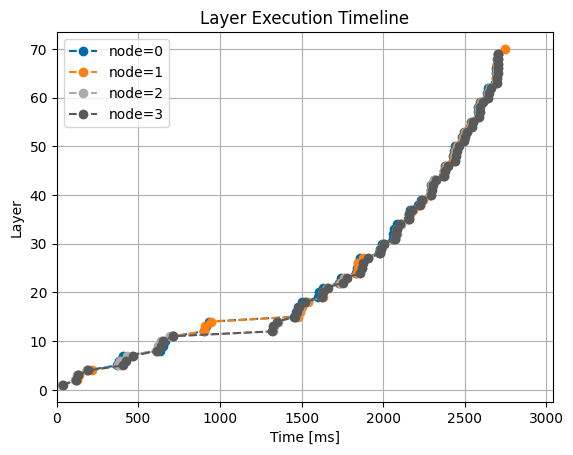

In [8]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(layer_event_df[layer_event_df['node'] == i]['time'] ,layer_event_df[layer_event_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [ms]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))
plt.xlim(0,max(total_runtime)*1.1*1e3)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



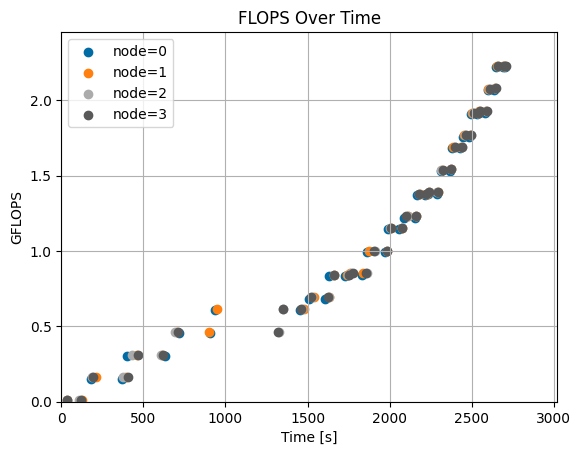

In [9]:

plt.figure()
plt.grid()
legend_strs = []
max_cum_bytes = 0
for i in range(num_nodes):

    tmp_merged_layer_df = layer_event_df[layer_event_df['node'] == i]
    nan_mask = tmp_merged_layer_df['FLOPS'].isna() == 0
    cum_bytes = np.cumsum(tmp_merged_layer_df[nan_mask]['FLOPS'].to_numpy())
    plt.scatter(tmp_merged_layer_df[nan_mask]['time'] ,cum_bytes/1e9)

    if max_cum_bytes < cum_bytes[-1]:
        max_cum_bytes = cum_bytes[-1]/1e9

    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
plt.xlim(0, max(layer_event_df['time'])*1.1)
plt.ylim(0,max_cum_bytes*1.1)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


In [10]:
layer_event_df['FLOPS']

3     9437184.0
2     9437184.0
2     9437184.0
1      524288.0
1      524288.0
        ...    
65      40800.0
67          NaN
68          NaN
65      40800.0
0           NaN
Name: FLOPS, Length: 276, dtype: float64

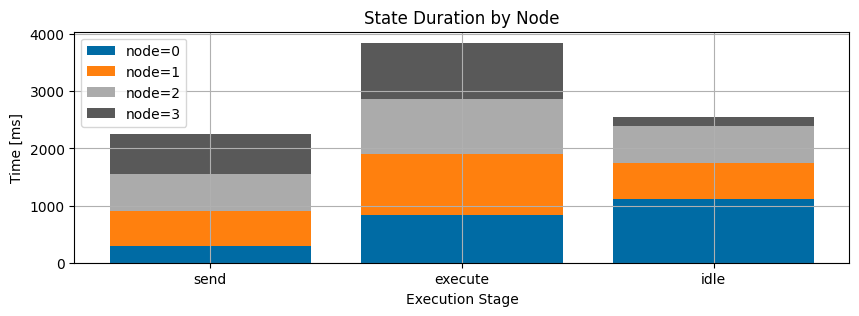

In [11]:
'''
    WIP Compare durations from different states 

'''

stages = ["send", "execute", "idle"]
num_stages = len(stages)
legend_strs = []

plt.figure(figsize=(10,3))
plt.grid()
bot = np.zeros(num_stages)
for inode in range(4):

    stages_array = np.array([])
    for a_stage in stages:
        stages_array = np.append(stages_array, block_event_df[(block_event_df['node'] == inode) & (block_event_df['type'] == a_stage) ]['dur'].sum(axis=0))
    plt.bar(stages, stages_array, bottom=bot)
    bot += stages_array

    legend_strs += [f'node={inode}']

plt.title(f'State Duration by Node')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, f'state_dur_compare_node-{test_name}.jpg'))

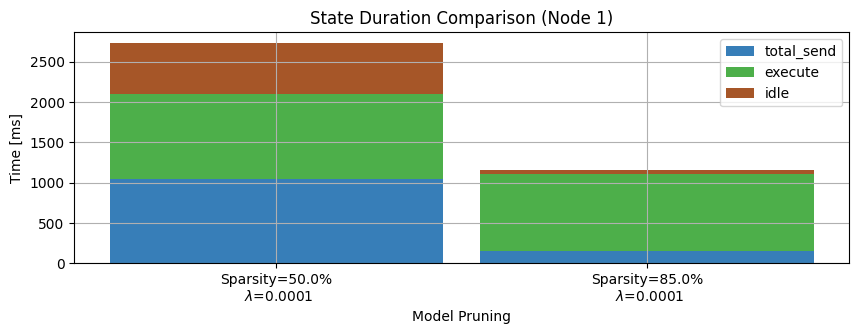

In [13]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''

 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
legend_strs = []

width = 0.9

# make plot 
plt.figure(figsize=(10,3))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    model_params = run_names[irun].split('-')
    sparsity_percent = 100*float(model_params[4][2:])
    lcm = float(model_params[5][3:] + '-' + model_params[6])
    model_names.append(f'Sparsity={sparsity_percent}%\n $\lambda$={lcm}')

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stages_array = np.append(stages_array, master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0))

    # plot 
    plt.bar(model_names, stages_array, width=width, align='center', bottom=bottom, color=CB_color_cycle_short[istage])

    # increase counters
    bottom += stages_array
    istage += 1
    irun += 1

#ax = plt.gca()
#ax.set_yscale('log')

# labels
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Pruning')
plt.ylabel('Time [ms]')
plt.legend(stages)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare_stacked.jpg'))

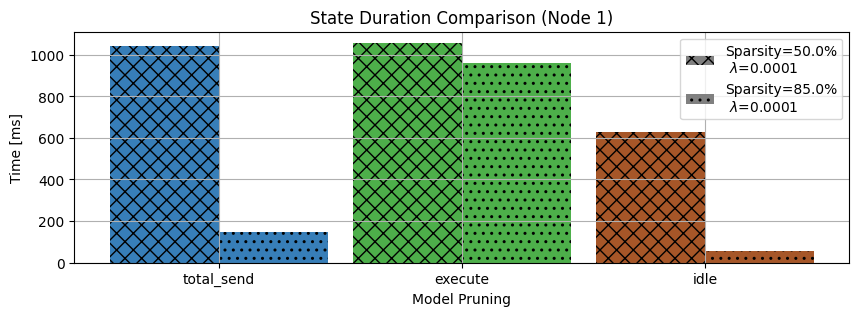

In [12]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''
 
CB_color_cycle_short = ['#377eb8', '#4daf4a', '#a65628']
hatch_list = ["xx", "..", "\\\\", "**"]
stages = ['total_send','execute', 'idle']
num_stages = len(stages)

# ticks 
width = 0.9
stage_values = np.arange(num_stages)*num_runs
run_values = np.arange(num_runs)*width
legend_strs = []

# make plot 
plt.figure(figsize=(10,3))
plt.grid()

# iterators
inode = 1
data_frames = []
model_names= []
bottom = np.zeros(num_runs)

# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    data_frames.append( split_run_results.combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] )

    model_params = run_names[irun].split('-')
    sparsity_percent = 100*float(model_params[4][2:])
    lcm = float(model_params[5][3:] + '-' + model_params[6])
    model_names.append(f'Sparsity={sparsity_percent}%\n $\lambda$={lcm}')

    # make dummy bar for legend 
    plt.bar(0, 0, color="gray",  hatch= hatch_list[irun])

# plot 1 stage at a time 
istage = 0
for a_stage in stages:

    # fill array with value for each run 
    stages_array = np.array([])
    for irun in range(num_runs):
        master_tmp = data_frames[irun] 
        stage_time = master_tmp[(master_tmp['type'] == a_stage) & (master_tmp['node']==inode)]['dur'].sum(axis=0)

        # plot 
        plt.bar(stage_values[istage] + run_values[irun] - width/num_runs,
                    stage_time,
                    width=width,
                    align='center', 
                    color=CB_color_cycle_short[istage], 
                    hatch= hatch_list[irun])

    # increase counters
    istage += 1
    irun += 1

# labels
plt.xticks(stage_values, stages)
plt.title(f'State Duration Comparison (Node {inode})')
plt.xlabel('Model Pruning')
plt.ylabel('Time [ms]')
plt.legend(model_names)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_dur_compare.jpg'))

## Animations

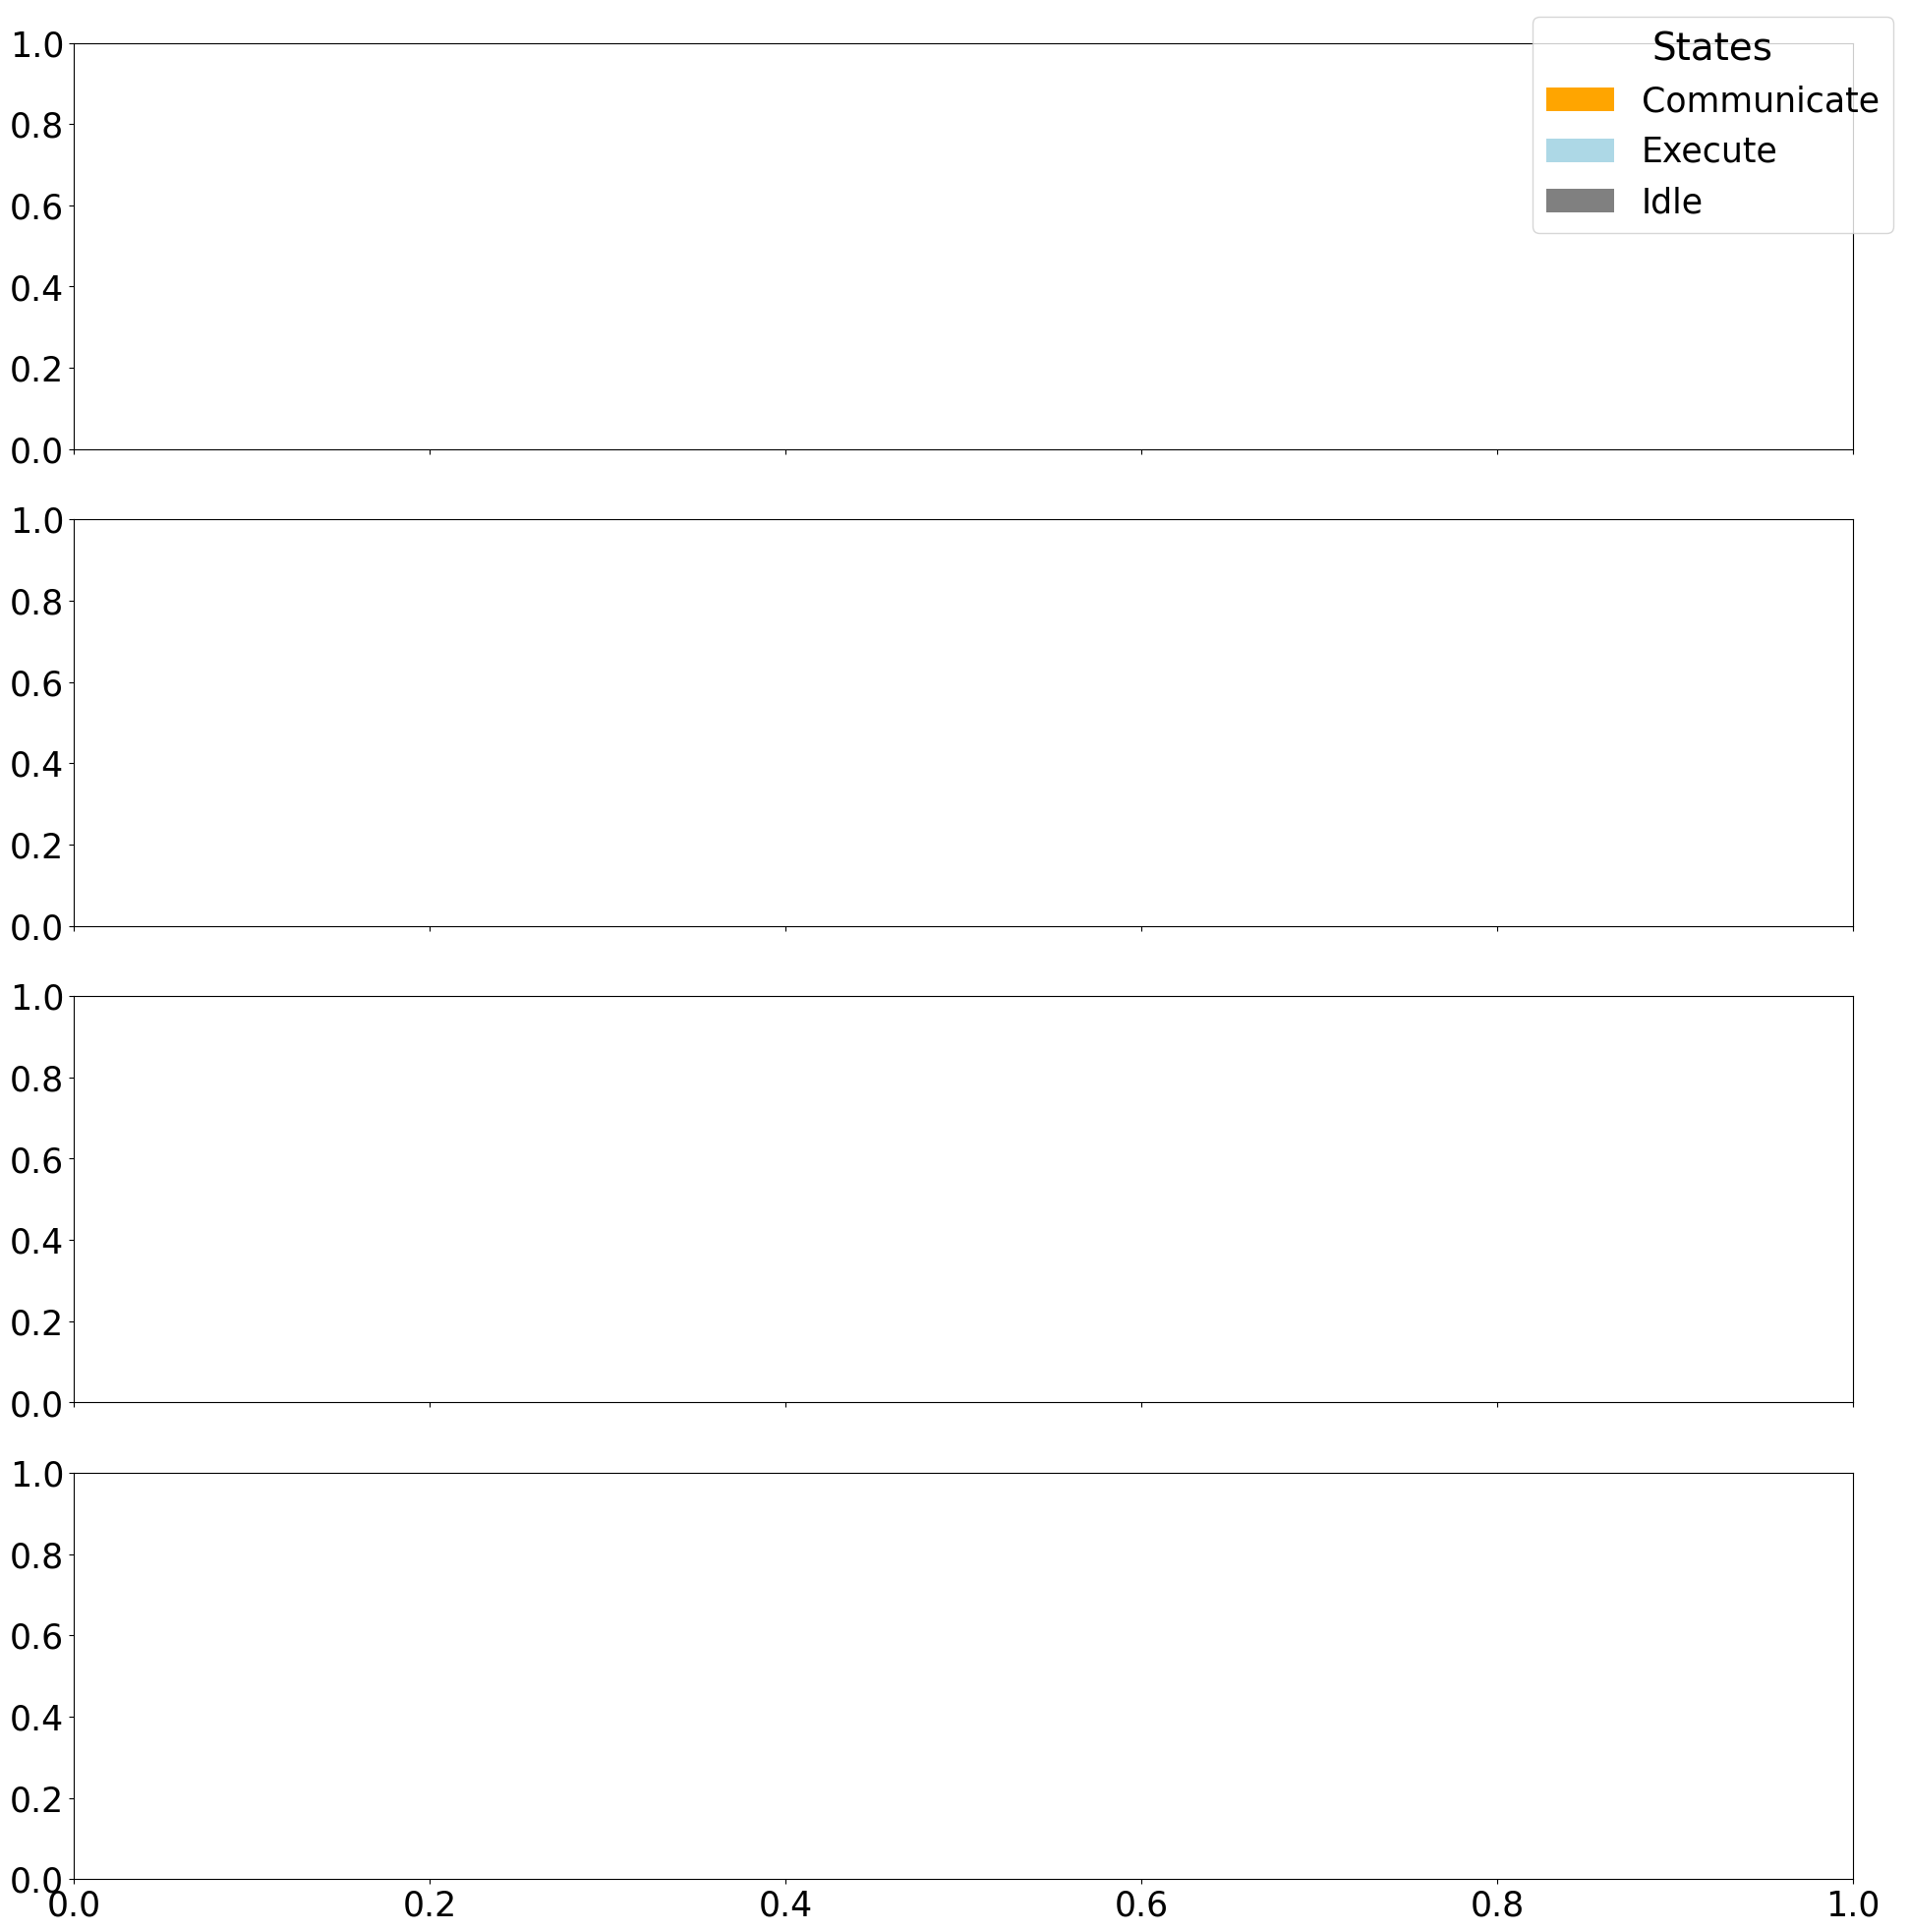

In [156]:
def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# Define parameters
yheight = 1
ystep = 1

# Replace 'num_nodes' with the actual number of nodes in your data
num_nodes = block_event_df['node'].nunique()
comms_width = yheight / num_nodes

# Merge 'receive', 'prep', and 'total_send' into 'Communicate'
state_types = ['Communicate', 'Execute', 'Idle']
state_type_positions = {state: idx for idx, state in enumerate(state_types)}
state_colors = {
    'Communicate': 'orange',  # Color for 'Communicate' state
    'Execute': 'lightblue',
    'Idle': 'gray',
}

num_states = len(state_types)
max_time = (block_event_df['time'] + block_event_df['dur']).max()

# Preprocess data outside the animate function
plot_data = {}  # Dictionary to store data for each node and state
for inode in range(num_nodes):
    plot_data[inode] = {}
    node_df = block_event_df[block_event_df['node'] == inode]

    # Combine 'receive', 'prep', and 'total_send' into 'Communicate'
    communicate_df = node_df[node_df['type'].isin(['receive', 'prep', 'total_send'])]
    communicate_bars = seq_of_tuples(communicate_df, 'time', 'dur')
    plot_data[inode]['Communicate'] = communicate_bars

    # Process 'Execute' and 'Idle' states
    for state in ['Execute', 'Idle']:
        df_state = node_df[node_df['type'] == state.lower()]
        bars = seq_of_tuples(df_state, 'time', 'dur')
        plot_data[inode][state] = bars

# Set up the figure and axes with increased font sizes
plt.rcParams.update({'font.size': 25})  # Increase the global font size

fig, axs = plt.subplots(num_nodes, 1, figsize=(20, 20), sharex=True)

# Create legend entries with increased font size
legend_patches = []
for state in state_types:
    patch = Patch(facecolor=state_colors[state], label=state)
    legend_patches.append(patch)

# Add the legend to the figure (only once)
fig.legend(handles=legend_patches, loc='upper right', title='States', fontsize=25, title_fontsize=28)

def animate(frame_num):
    current_time = frame_num * 20  # Update every 50 ms
    for inode in range(num_nodes):
        ax = axs[inode]
        ax.clear()  # Clear the axis

        # Set labels and limits
        ax.set_ylabel(f'Node {inode}')
        ax.set_yticks([])
        ax.set_xlim(0, max_time_runs)
        ax.set_ylim(0, num_states * ystep)  # Adjusted ylim to start from 0
        ax.grid(True, axis='x')  # Add vertical grid only

        # Plot the bars for each state
        for istate, state in enumerate(state_types):
            bars = plot_data[inode][state]
            for bar in bars:
                start_time, duration = bar
                end_time = start_time + duration
                if end_time < 0 or start_time > current_time:
                    continue
                plot_start_time = max(start_time, 0)
                plot_end_time = min(end_time, current_time)
                plot_dur = plot_end_time - plot_start_time
                if plot_dur <= 0:
                    continue
                rect = patches.Rectangle(
                    (plot_start_time, ystep * istate),
                    plot_dur,
                    yheight,
                    facecolor=state_colors[state],
                    edgecolor='none'
                )
                ax.add_patch(rect)

        # Optional: Add node title within the animate function if titles need to be updated
        ax.set_title(f'Node {inode}')

num_frames = int(max_time_runs / 20) + 1

ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    interval=20,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Save as MP4 using FFmpeg or adjust as needed
    ani.save(os.path.join(save_dir, 'block_execution_time_animation_10.mp4'), writer='ffmpeg', fps=5)


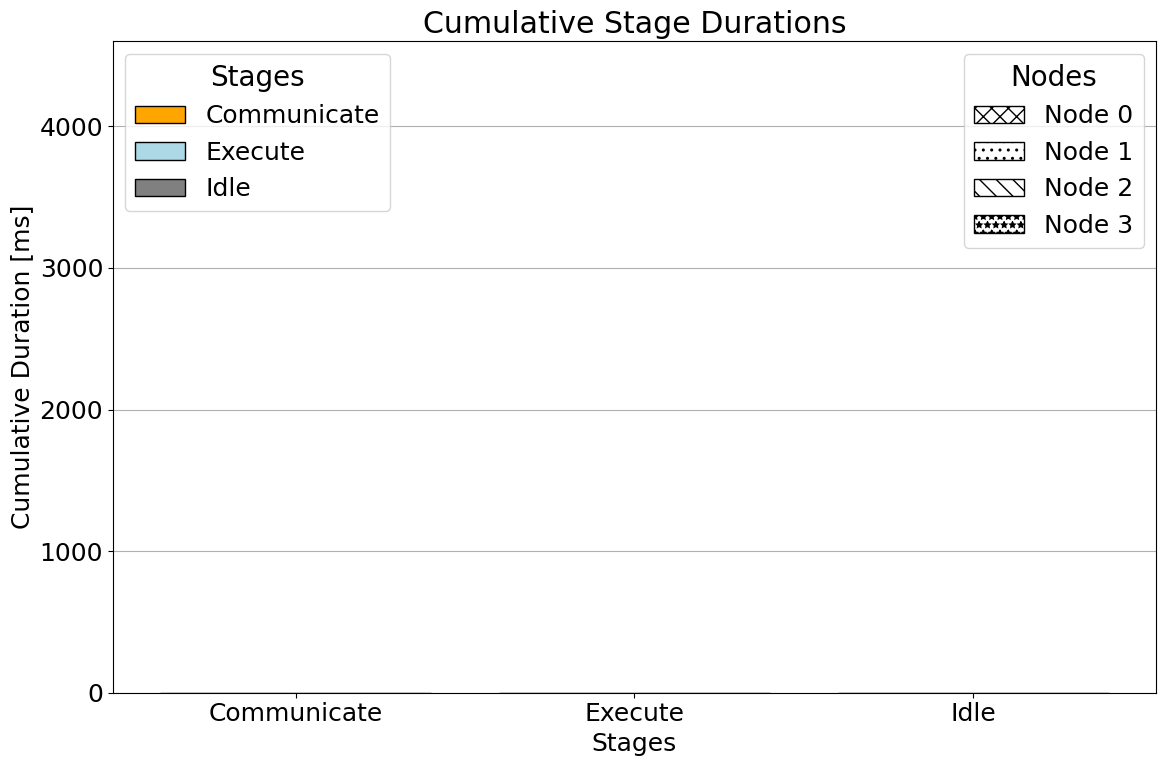

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
import os

# Assume 'data_frame' is your DataFrame for one run
# It should have columns: 'node', 'type', 'time', 'dur'
# Also assume 'max_time' is defined (maximum end time of events)
data_frame = block_event_df

# Define new stages and nodes
stages = ['Communicate', 'Execute', 'Idle']
num_stages = len(stages)
num_nodes = data_frame['node'].nunique()  # Get the number of nodes from the data

# Define colors and hatches
stage_colors = ['orange', 'lightblue', 'gray']  # Colors for the stages
hatch_list = ["xx", "..", "\\\\", "**"]  # Hatches for the nodes


# Define time steps for the animation
dt = 20  # Time step in ms
data_frame['end_time'] = data_frame['time'] + data_frame['dur']
max_time = data_frame['end_time'].max()
time_steps = np.arange(0, max_time_runs + dt, dt)
num_time_steps = len(time_steps)

# Initialize cumulative_durations array
# Shape: (num_nodes, num_stages, num_time_steps)
cumulative_durations = np.zeros((num_nodes, num_stages, num_time_steps))

# Map for the original types to new stages
type_to_stage = {
    'total_send': 'Communicate',
    'receive': 'Communicate',
    'execute': 'Execute',
    'idle': 'Idle'
}

# Compute cumulative durations for each node, stage, and time step
for node in range(num_nodes):
    node_df = data_frame[data_frame['node'] == node]
    for stage_idx, stage in enumerate(stages):
        if stage == 'Communicate':
            # Include both 'total_send' and 'receive' events
            events = node_df[node_df['type'].isin(['total_send', 'receive'])]
        else:
            # For other stages, select events where type matches the stage name (case-insensitive)
            events = node_df[node_df['type'].str.lower() == stage.lower()]
        event_start_times = events['time'].values  # Shape: (N,)
        event_durs = events['dur'].values  # Shape: (N,)
        if len(event_start_times) == 0:
            continue
        # Compute contributions over time steps
        contributions = np.clip(
            time_steps[np.newaxis, :] - event_start_times[:, np.newaxis],
            0,
            event_durs[:, np.newaxis]
        )
        cumulative_durations[node, stage_idx, :] = contributions.sum(axis=0)

# Initialize the figure and axes with larger font sizes
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(12, 8))

x_positions = np.arange(num_stages)  # Positions for stages
bar_width = 0.8 / num_nodes  # Bar width per node

# Initialize bars and store them in a dictionary
bars = {}  # bars[node][stage_idx] = bar

for node in range(num_nodes):
    x = x_positions + (node - (num_nodes - 1)/2) * bar_width
    node_bars = []
    for stage_idx, stage in enumerate(stages):
        bar = ax.bar(
            x[stage_idx],
            0,  # Initial height
            width=bar_width,
            color=stage_colors[stage_idx],
            hatch=hatch_list[node],
            edgecolor='black'
        )
        node_bars.append(bar[0])  # bar() returns a container; get the Bar object
    bars[node] = node_bars

# Set labels and title
ax.set_xticks(x_positions)
ax.set_xticklabels(stages)
ax.set_xlabel('Stages')
ax.set_ylabel('Cumulative Duration [ms]')
ax.set_ylim([0, 4600]) ############################################ max_time
ax.set_title('Cumulative Stage Durations')
ax.grid(True, axis='y')  # Add horizontal grid lines

# Create custom legend entries
# Legend for nodes (hatches)
node_patches = [
    Patch(facecolor='white', edgecolor='black', hatch=hatch_list[node], label=f'Node {node}')
    for node in range(num_nodes)
]

# Legend for stages (colors)
stage_patches = [
    Patch(facecolor=stage_colors[stage_idx], edgecolor='black', label=stage)
    for stage_idx, stage in enumerate(stages)
]

# Add legends to the plot with larger font sizes
legend1 = ax.legend(handles=stage_patches, title='Stages', loc='upper left', fontsize=18, title_fontsize=20)
legend2 = ax.legend(handles=node_patches, title='Nodes', loc='upper right', fontsize=18, title_fontsize=20)
ax.add_artist(legend1)  # Add the first legend back to the axes

def animate(frame):
    t = time_steps[frame]
    for node in range(num_nodes):
        for stage_idx in range(num_stages):
            height = cumulative_durations[node, stage_idx, frame]
            bar = bars[node][stage_idx]
            bar.set_height(height)
    ax.set_title(f'Cumulative Stage Durations')
    return [bar for node_bars in bars.values() for bar in node_bars]

# Create the animation
ani = FuncAnimation(
    fig,
    animate,
    frames=num_time_steps,
    interval=20,  # Adjust the interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'ffmpeg' installed for MP4 output
    ani.save(os.path.join(save_dir, 'state_dur_compare_animation.mp4'), writer='ffmpeg', fps=5)


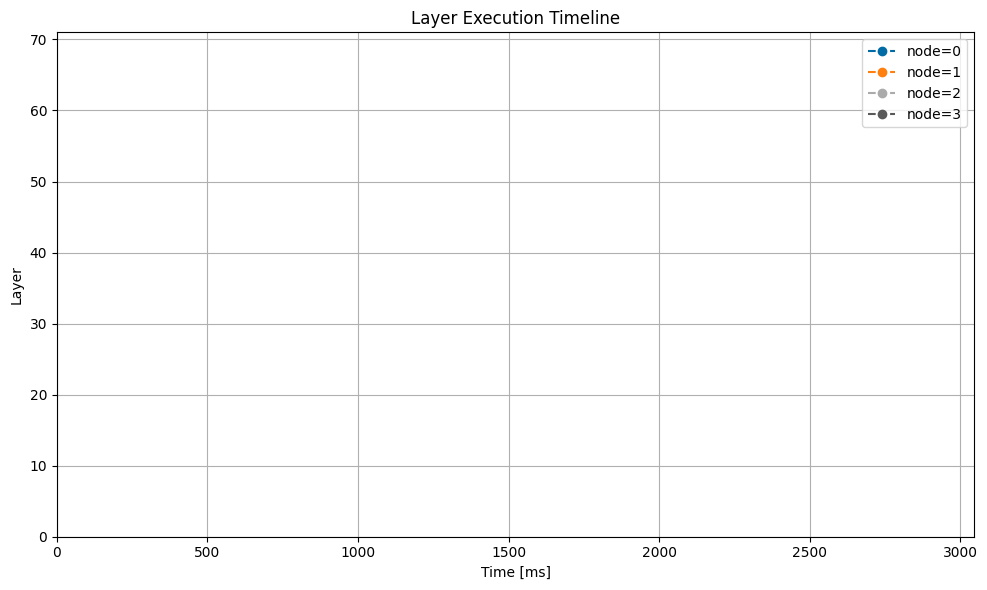

In [95]:
# Parameters
num_nodes = 4  # Number of nodes (0 to 3)
dt = 50        # Time step in milliseconds
#max_time = layer_event_df['time'].max()
time_steps = np.arange(0, max_time + dt, dt)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.set_title('Layer Execution Timeline')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Layer')
ax.set_xlim(0, max_time * 1.1)
ax.set_ylim(layer_event_df['layer'].min() - 1, layer_event_df['layer'].max() + 1)

# Initialize lines for each node
lines = []
legend_strs = []
for i in range(num_nodes):
    line, = ax.plot([], [], '--o', label=f'node={i}')
    lines.append(line)
    legend_strs.append(f'node={i}')

ax.legend()

# Preprocess data for each node
node_data = {}
for i in range(num_nodes):
    df_node = layer_event_df[layer_event_df['node'] == i].sort_values('time')
    node_data[i] = df_node

def init():
    # Initialize empty data for each line
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    current_time = time_steps[frame]
    for i, line in enumerate(lines):
        df_node = node_data[i]
        # Filter data up to the current time
        df_node_current = df_node[df_node['time'] <= current_time]
        x_data = df_node_current['time'].values
        y_data = df_node_current['layer'].values
        line.set_data(x_data, y_data)
    ax.set_xlim(0, max_time * 1.1)
    ax.set_ylim(layer_event_df['layer'].min() - 1, layer_event_df['layer'].max() + 1)
    ax.set_title(f'Layer Execution Timeline (Time: {current_time:.0f} ms)')
    return lines

# Create the animation
num_frames = len(time_steps)
ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    init_func=init,
    interval=100,  # Adjust interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'pillow' installed (`pip install pillow`)
    ani.save(os.path.join(save_dir, 'layer_execution_time_animation.gif'), writer='pillow', fps=10)


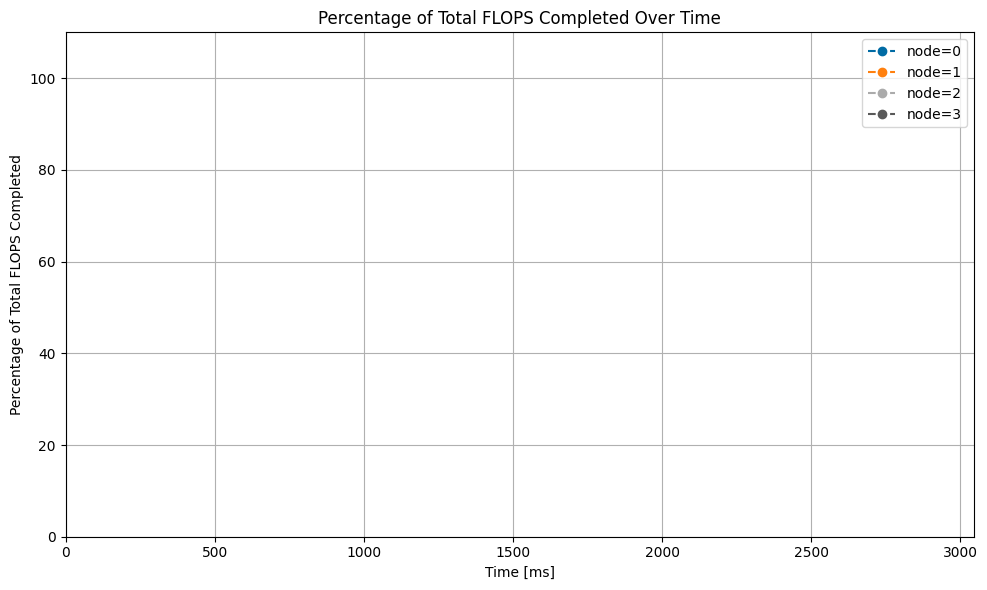

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

# Assuming 'layer_event_df' is your DataFrame with columns: 'time', 'FLOPS', 'node'
# Also assuming 'num_nodes' is defined

# Parameters
num_nodes = layer_event_df['node'].nunique()
dt = 50  # Time step in milliseconds
#max_time = layer_event_df['time'].max()
time_steps = np.arange(0, max_time + dt, dt)

# Preprocess data per node
node_data = {}
total_flops = {}

for i in range(num_nodes):
    df_node = layer_event_df[layer_event_df['node'] == i].sort_values('time')
    # Remove NaNs in 'FLOPS'
    df_node = df_node[df_node['FLOPS'].notna()].reset_index(drop=True)
    node_data[i] = df_node
    # Compute total FLOPS per node
    total_flops[i] = df_node['FLOPS'].sum()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.set_title('Percentage of Total FLOPS Completed Over Time')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Percentage of Total FLOPS Completed')
ax.set_xlim(0, max_time * 1.1)
ax.set_ylim(0, 110)  # Percentage from 0% to 100%

# Initialize lines for each node
lines = []
for i in range(num_nodes):
    line, = ax.plot([], [], '--o', label=f'node={i}')
    lines.append(line)

ax.legend()

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    current_time = time_steps[frame]
    for i, line in enumerate(lines):
        df_node = node_data[i]
        # Filter data up to the current time
        df_node_current = df_node[df_node['time'] <= current_time]
        if df_node_current.empty:
            x_data = []
            y_data = []
        else:
            cum_flops = np.cumsum(df_node_current['FLOPS'].values)
            # Calculate percentage of total FLOPS completed
            percentage = (cum_flops / total_flops[i]) * 100
            x_data = df_node_current['time'].values
            y_data = percentage
        line.set_data(x_data, y_data)
    ax.set_title(f'Percentage of Total FLOPS Completed (Time: {current_time:.0f} ms)')
    return lines

num_frames = len(time_steps)
ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    init_func=init,
    interval=100,  # Adjust interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'pillow' installed (`pip install pillow`)
    ani.save(os.path.join(save_dir, 'FLOPS_percentage_animation.gif'), writer='pillow', fps=10)


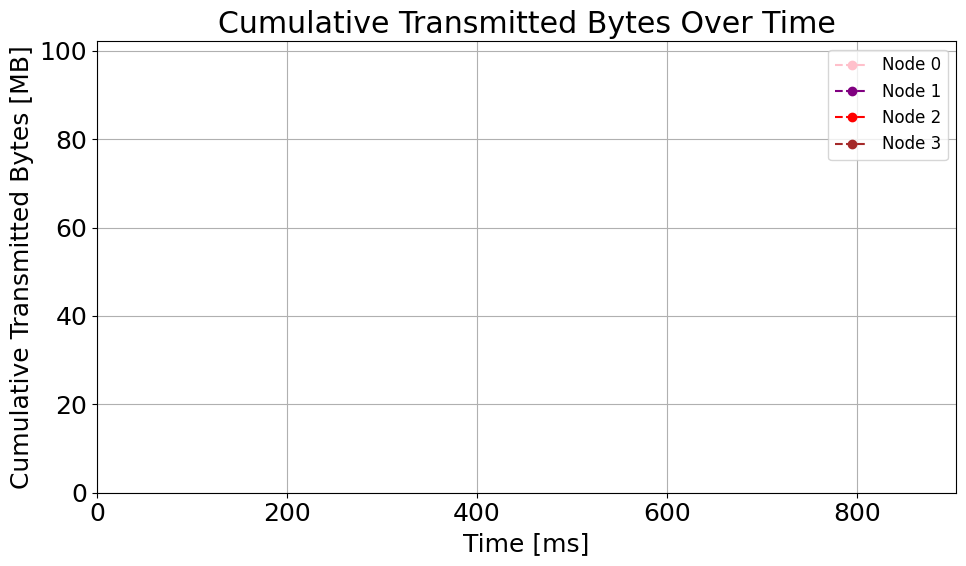

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd

# Assuming 'block_event_df' is your DataFrame with columns: 'time', 'bytes_tx', 'node', 'type'
# Also assuming 'num_nodes' is defined

dense_max_bytes = 92873702
# Parameters
colors = ['pink', 'purple', 'red', 'brown']
num_nodes = block_event_df['node'].nunique()
dt = 20  # Time step in milliseconds
max_time = block_event_df['time'].max()
time_steps = np.arange(0, max_time + dt, dt)

# Preprocess data per node
node_data = {}
max_cum_bytes = 0  # To keep track of the maximum cumulative bytes across all nodes

for i in range(num_nodes):
    # Filter data for the node and where 'type' is 'send' and 'bytes_tx' is not null
    df_node = block_event_df[
        (block_event_df['node'] == i) &
        (block_event_df['type'] == 'send') &
        (block_event_df['bytes_tx'].notna())
    ].sort_values('time')
    # Reset index after filtering
    df_node = df_node.reset_index(drop=True)
    node_data[i] = df_node
    # Compute cumulative sum of 'bytes_tx' for the node
    cum_bytes = np.cumsum(df_node['bytes_tx'].values)
    if len(cum_bytes) > 0:
        max_cum_bytes = max(max_cum_bytes, cum_bytes[-1])

# Increase global font size
plt.rcParams.update({'font.size': 18})

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.set_title('Cumulative Transmitted Bytes Over Time')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Cumulative Transmitted Bytes [MB]')
ax.set_xlim(0, max_time * 1.1)
ax.set_ylim(0, dense_max_bytes / 1e6 * 1.1)  # Convert bytes to megabytes (MB)

# Initialize lines for each node
lines = []
for i in range(num_nodes):
    line, = ax.plot([], [], '--o', label=f'Node {i}', color=colors[i])
    lines.append(line)

# Update the legend with increased font size
ax.legend(fontsize=12, title_fontsize=14)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    current_time = time_steps[frame]
    for i, line in enumerate(lines):
        df_node = node_data[i]
        # Filter data up to the current time
        df_node_current = df_node[df_node['time'] <= current_time]
        if df_node_current.empty:
            x_data = []
            y_data = []
        else:
            cum_bytes = np.cumsum(df_node_current['bytes_tx'].values)
            x_data = df_node_current['time'].values
            y_data = cum_bytes / 1e6  # Convert bytes to megabytes (MB)
        line.set_data(x_data, y_data)
    ax.set_title(f'Cumulative Transmitted Bytes Over Time') # (Time: {current_time:.0f} ms)
    return lines

num_frames = len(time_steps)
ani = FuncAnimation(
    fig,
    animate,
    frames=num_frames,
    init_func=init,
    interval=20,  # Adjust interval as needed
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()

# Save the animation if needed
if DO_SAVE:
    # Ensure you have 'pillow' or 'ffmpeg' installed
    ani.save(os.path.join(save_dir, 'cumulative_transmitted_bytes_animation.mp4'), writer='ffmpeg', fps=5)


In [151]:
print(max_cum_bytes)

92873702.0


## Static plots

In [178]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Placeholder values for sparsity levels and accuracies
accuracies = {'run1': 71.62, 'run2': 71.56}     # Accuracies for each run (85% and 80%)
runs = ['run1', 'run2']
dataframes = {}
sparsity_levels = {'run1': 0, 'run2': 50}
# get df for each run 
for irun in range(num_runs):
    run_name = run_names[irun]
    block_event_df = split_run_results.combine_log_files(os.path.join('demo_logs', run_name), log_name, num_nodes)[0]
    run_idx = runs[irun]
    dataframes[run_idx] = block_event_df

plot_names = {'run1': 'Dense', 'run2': 'PR: 0.50'}
colors = {'run1': 'green', 'run2': 'blue'}  # Consistent colors for the runs
state_colors = {'total_send': 'orange', 'execute': 'lightblue', 'idle': 'gray'}
state_types = ['total_send', 'execute', 'idle']
DO_SAVE = True  # Set to True if you want to save the plots
save_dir = 'static_plots_densevs05'  # Directory to save the plots

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


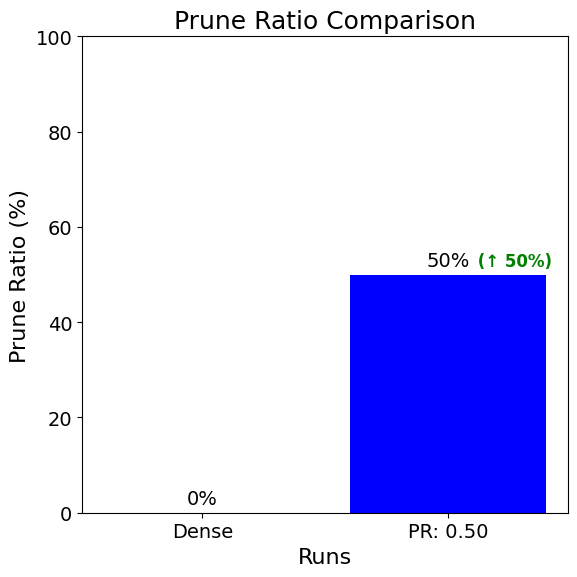

In [103]:
# First plot: Prune Ratio Comparison
prune_ratio_values = [sparsity_levels[run] for run in runs]

# Increase global font size
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(6, 6))
bars = plt.bar(list(plot_names.values()), prune_ratio_values, color=[colors[run] for run in runs])
plt.xlabel('Runs', fontsize=16)
plt.ylabel('Prune Ratio (%)', fontsize=16)
plt.ylim([0,100])
plt.title('Prune Ratio Comparison', fontsize=18)

# Adding value labels and difference for run2
for idx, (bar, value) in enumerate(zip(bars, prune_ratio_values)):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Value label
    plt.text(x, y + 1, f'{value:.0f}%', ha='center', va='bottom', fontsize=14)
    
    # For run2, add difference compared to run1
    if runs[idx] == 'run2':
        prune_ratio_run1 = sparsity_levels['run1']
        prune_ratio_run2 = sparsity_levels['run2']
        # Calculate the difference in percentage points
        difference = prune_ratio_run2 - prune_ratio_run1

        # Determine arrow and color
        if difference > 0:
            arrow = '↑'
            color = 'green'  # Increase is positive for prune ratio
        elif difference < 0:
            arrow = '↓'
            color = 'red'    # Decrease is negative for prune ratio
        else:
            arrow = ''
            color = 'black'

        # Format difference text
        difference_text = f" ({arrow} {abs(difference):.0f}%)"
        # Place the difference text next to the value label
        plt.text(x + 0.1, y + 1, difference_text,
                 ha='left', va='bottom', color=color, fontweight='bold', fontsize=12)

# Adjust layout and save the figure
plt.tight_layout()
if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'prune_ratio_comparison.pdf'),
                transparent=True, bbox_inches='tight')

plt.show()


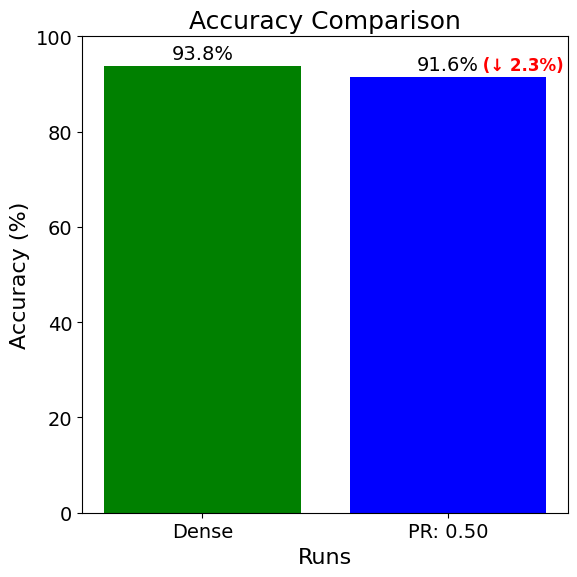

In [104]:
# Second plot: Accuracy comparison
accuracy_values = [accuracies[run] for run in runs]

# Increase global font size
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(6, 6))
bars = plt.bar(list(plot_names.values()), accuracy_values, color=[colors[run] for run in runs])
plt.xlabel('Runs', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=16)
plt.ylim([0,100])
plt.title('Accuracy Comparison', fontsize=18)

# Adding value labels and difference for run2
for idx, (bar, value) in enumerate(zip(bars, accuracy_values)):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Value label
    plt.text(x, y + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=14)

    # For run2, add difference compared to run1
    if runs[idx] == 'run2':
        accuracy_run1 = accuracies['run1']
        accuracy_run2 = accuracies['run2']
        # Calculate the difference in percentage points
        difference = accuracy_run2 - accuracy_run1

        # Determine arrow and color
        if difference > 0:
            arrow = '↑'
            color = 'green'  # Increase is positive for accuracy
        elif difference < 0:
            arrow = '↓'
            color = 'red'    # Decrease is negative for accuracy
        else:
            arrow = ''
            color = 'black'

        # Format difference text
        difference_text = f" ({arrow} {abs(difference):.1f}%)"
        # Place the difference text next to the value label
        plt.text(x + 0.12, y + 0.5, difference_text,
                 ha='left', va='bottom', color=color, fontweight='bold', fontsize=12)

# Adjust layout and save the figure
plt.tight_layout()
if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'accuracy_comparison.pdf'),
                bbox_inches='tight')

plt.show()

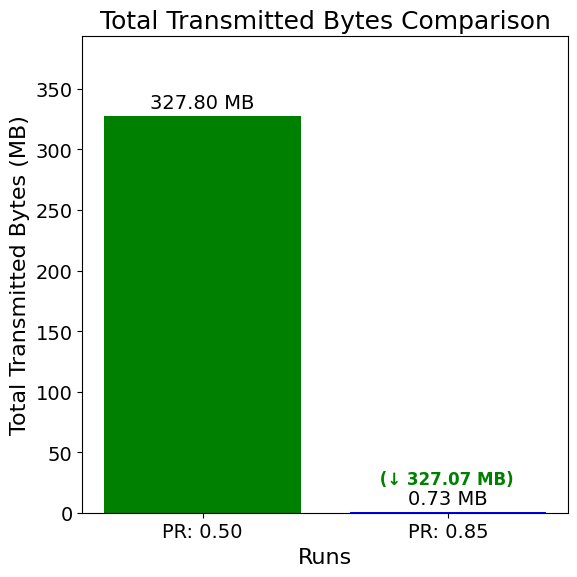

In [170]:
# Third plot: Total transmitted bytes comparison
total_bytes = {}
for run in runs:
    df = dataframes[run]
    total_bytes[run] = df.loc[
        (df['type'] == 'send') & (df['bytes_tx'].notnull()), 'bytes_tx'
    ].sum()

total_bytes_values = [total_bytes[run] for run in runs]
# Convert bytes to Megabytes (MB)
total_bytes_mb = [value / 1e6 for value in total_bytes_values]

# Increase global font size
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(6, 6))
bars = plt.bar(list(plot_names.values()), total_bytes_mb, color=[colors[run] for run in runs])
plt.xlabel('Runs', fontsize=16)
plt.ylabel('Total Transmitted Bytes (MB)', fontsize=16)
plt.ylim([0,max(total_bytes_mb)*1.2])
plt.title('Total Transmitted Bytes Comparison', fontsize=18)

# Adding value labels and difference for run2
for idx, (bar, value) in enumerate(zip(bars, total_bytes_mb)):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Value label
    plt.text(x, y + max(total_bytes_mb) * 0.01, f'{value:.2f} MB', ha='center', va='bottom', fontsize=14)

    # For run2, add difference compared to run1
    if runs[idx] == 'run2':
        total_bytes_run1 = total_bytes['run1']
        total_bytes_run2 = total_bytes['run2']
        # Calculate the difference in megabytes
        difference_mb = (total_bytes_run2 - total_bytes_run1) / 1e6

        # Since lower total bytes is better, invert logic
        if difference_mb < 0:
            arrow = '↓'
            color = 'green'  # Decrease is positive for total transmitted bytes
        elif difference_mb > 0:
            arrow = '↑'
            color = 'red'    # Increase is negative for total transmitted bytes
        else:
            arrow = ''
            color = 'black'

        # Format difference text
        difference_text = f" ({arrow} {abs(difference_mb):.2f} MB)"
        # Place the difference text next to the value label
        plt.text(x-0.3, y + max(total_bytes_mb) * 0.06, difference_text,
                 ha='left', va='bottom', color=color, fontweight='bold', fontsize=12)

# Adjust layout and save the figure
plt.tight_layout()
if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'total_transmitted_bytes_comparison.pdf'),
                bbox_inches='tight')

plt.show()

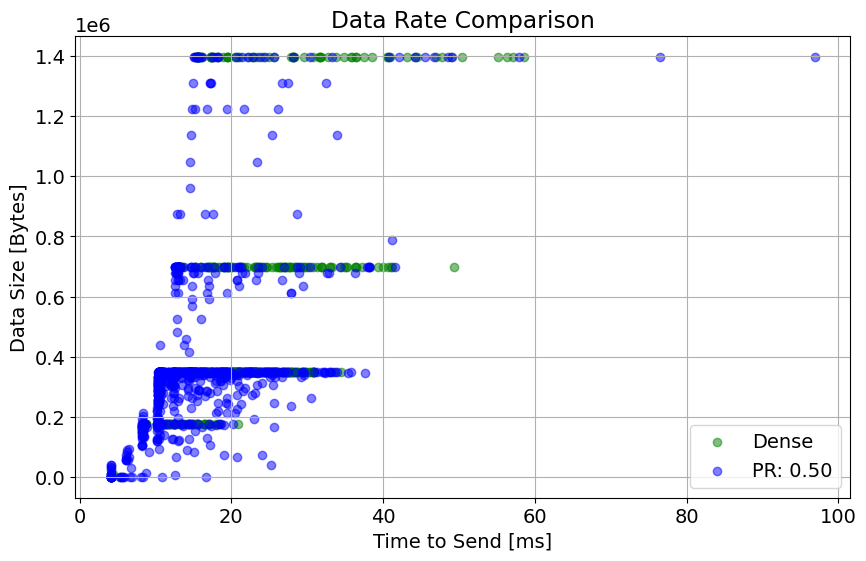

In [108]:
# Fourth plot: Scatterplot of transmitted sizes vs time to send
plt.figure(figsize=(10, 6))
for run in runs:
    df = dataframes[run]
    df_send = df[(df['type'] == 'send') & df['bytes_tx'].notnull()]
    plt.scatter(df_send['dur'], df_send['bytes_tx'], color=colors[run], alpha=0.5, label=plot_names[run])

plt.xlabel('Time to Send [ms]')
plt.ylabel('Data Size [Bytes]')
plt.title('Data Rate Comparison')
plt.legend()
plt.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'data_rate_comparison.pdf'), bbox_inches='tight')

plt.show()


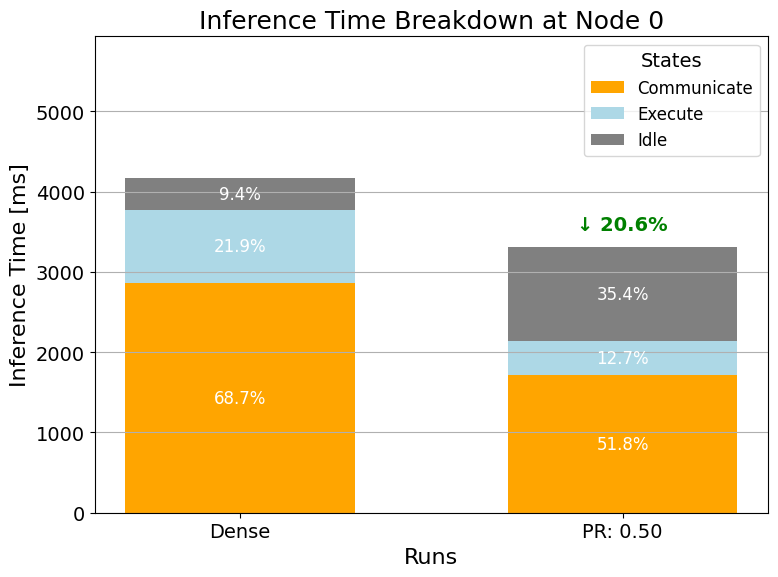

In [114]:
# Node to analyze
node = 0

# Define the new state names and colors
state_types = ['Communicate', 'Execute', 'Idle']
state_colors = {
    'Communicate': 'orange',  # Color for 'Communicate' state
    'Execute': 'lightblue',
    'Idle': 'gray',
}

# Collect execution times for each state and run
execution_times = {}
for run in runs:
    df = dataframes[run]
    df_node = df[df['node'] == node]
    total_time = df_node.loc[df_node['type'].isin(['idle', 'execute', 'total_send']), 'dur'].sum()
    state_times = {}
    # Merge 'receive' and 'total_send' into 'Communicate'
    communicate_time = df_node.loc[df_node['type'].isin(['total_send']), 'dur'].sum() # receive
    state_times['Communicate'] = communicate_time
    # Get 'Execute' and 'Idle' times
    for state in ['Execute', 'Idle']:
        state_time = df_node.loc[df_node['type'] == state.lower(), 'dur'].sum()
        state_times[state] = state_time
    execution_times[run] = {'total_time': total_time, 'state_times': state_times}

# Prepare data for plotting
bar_width = 0.6
x = np.arange(len(runs))  # Positions for the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Increase font sizes
plt.rcParams.update({'font.size': 14})
ax.set_xlabel('Runs', fontsize=16)
ax.set_ylabel('Inference Time [ms]', fontsize=16)
ax.set_title(f'Inference Time Breakdown at Node {node}', fontsize=18)

# Add horizontal grid
ax.grid(True, axis='y')

# Initialize bottom values for stacking bars
bottoms = np.zeros(len(runs))

# Plot each state
for state in state_types:
    state_values = [execution_times[run]['state_times'][state] for run in runs]
    bars = ax.bar(x, state_values, bottom=bottoms, width=bar_width, color=state_colors[state], label=state)
    
    # Add percentage labels for each bar segment
    for idx, bar in enumerate(bars):
        total_time = execution_times[runs[idx]]['total_time']
        percent = (state_values[idx] / total_time) * 100 if total_time > 0 else 0
        if percent > 5:  # Only label segments larger than 5% to avoid clutter
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottoms[idx] + state_values[idx] / 2,
                f'{percent:.1f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=12
            )
    bottoms += state_values  # Update bottom values for stacking

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(list(plot_names.values()))
ax.legend(title='States', fontsize=12, title_fontsize=14)

# Adjust y-axis limit
ax.set_ylim(0, sum([max([execution_times[run]['state_times'][state] for run in runs]) for state in state_types]) * 1.2)

# Calculate percentage reduction for run2 compared to run1
total_time_run1 = execution_times['run1']['total_time']
total_time_run2 = execution_times['run2']['total_time']
if total_time_run1 != 0:
    percentage_change_time = ((total_time_run2 - total_time_run1) / total_time_run1) * 100
else:
    percentage_change_time = 0  # Avoid division by zero

# Determine arrow and color for the percentage change
if percentage_change_time < 0:
    arrow = '↓'
    color = 'green'  # Decrease is positive for execution time reduction
elif percentage_change_time > 0:
    arrow = '↑'
    color = 'red'    # Increase is negative for execution time
else:
    arrow = ''
    color = 'black'

# Format percentage change text
percentage_change_text = f"{arrow} {abs(percentage_change_time):.1f}%"

# Add the percentage change text on top of the second bar
x_pos = x[1]  # Position of the second bar
y_pos = bottoms[1] + max(bottoms[1] * 0.05, 10)
ax.text(
    x_pos,
    y_pos,
    percentage_change_text,
    ha='center',
    va='bottom',
    color=color,
    fontweight='bold',
    fontsize=14
)

plt.tight_layout()
if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'execution_time_breakdown_node1.pdf'), bbox_inches='tight')

plt.show()


### Static animated

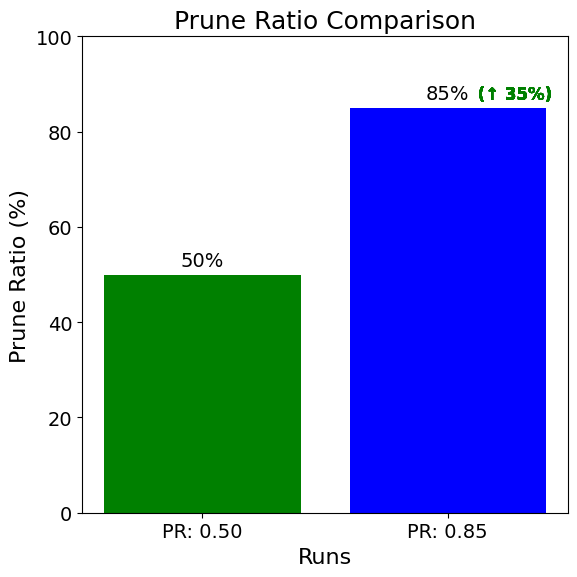

In [166]:
# Data for animation
prune_ratio_values = [sparsity_levels[run] for run in runs]
max_value = max(prune_ratio_values)

# Increase global font size
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6, 6))

bars = ax.bar(list(plot_names.values()), [0, 0], color=[colors[run] for run in runs])  # Start bars at height 0
ax.set_xlabel('Runs', fontsize=16)
ax.set_ylabel('Prune Ratio (%)', fontsize=16)
ax.set_title('Prune Ratio Comparison', fontsize=18)
ax.set_ylim(0, 100)  # Set y-axis limit to accommodate text

def animate(frame):
    for idx, bar in enumerate(bars):
        # Animate the height of the bars
        target_height = prune_ratio_values[idx]
        height = min(frame, target_height)
        bar.set_height(height)
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Remove any existing text
        if hasattr(bar, 'value_text'):
            bar.value_text.remove()
        # Value label
        bar.value_text = ax.text(x, y + 1, f'{height:.0f}%', ha='center', va='bottom', fontsize=14)
        # For run2, add difference
        if runs[idx] == 'run2' and frame >= target_height:
            prune_ratio_run1 = sparsity_levels['run1']
            prune_ratio_run2 = sparsity_levels['run2']
            difference = prune_ratio_run2 - prune_ratio_run1
            if difference > 0:
                arrow = '↑'
                color = 'green'
            elif difference < 0:
                arrow = '↓'
                color = 'red'
            else:
                arrow = ''
                color = 'black'
            difference_text = f" ({arrow} {abs(difference):.0f}%)"
            # Place the difference text next to the value label
            ax.text(x + 0.1, y + 1, difference_text,
                    ha='left', va='bottom', color=color, fontweight='bold', fontsize=12)

ani = FuncAnimation(
    fig,
    animate,
    frames=int(max_value) + 10,
    interval=50,
    repeat=False
)

plt.tight_layout()
if DO_SAVE:
    ani.save(os.path.join(save_dir, 'prune_ratio_comparison_animation.mp4'),
             writer='ffmpeg', fps=20)
plt.show()


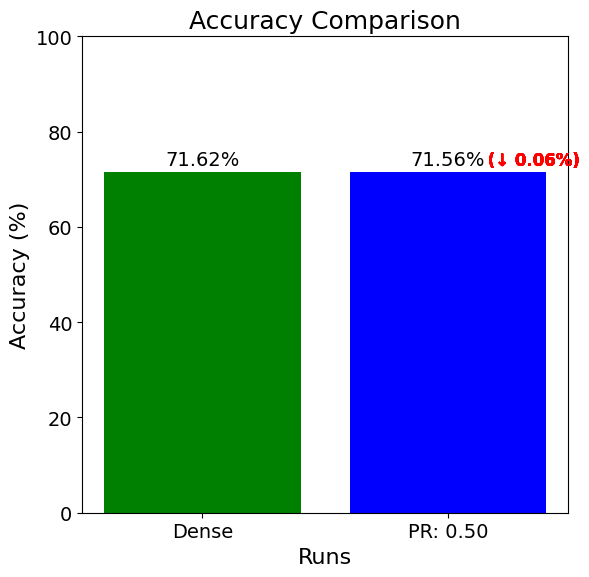

In [181]:
# Assuming 'accuracies', 'runs', 'colors', 'DO_SAVE', and 'save_dir' are already defined

# Data for animation
accuracy_values = [accuracies[run] for run in runs]
max_value = max(accuracy_values)

# Increase global font size
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6, 6))

bars = ax.bar(list(plot_names.values()), [0, 0], color=[colors[run] for run in runs])  # Start bars at height 0
ax.set_xlabel('Runs', fontsize=16)
ax.set_ylabel('Accuracy (%)', fontsize=16)
ax.set_title('Accuracy Comparison', fontsize=18)
ax.set_ylim(0, 100)  # Set y-axis limit to accommodate text

def animate(frame):
    for idx, bar in enumerate(bars):
        target_height = accuracy_values[idx]
        height = min(frame, target_height)
        bar.set_height(height)
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Remove any existing text
        if hasattr(bar, 'value_text'):
            bar.value_text.remove()
        # Value label
        bar.value_text = ax.text(x, y + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=14)
        # For run2, add difference
        if runs[idx] == 'run2' and frame >= target_height:
            accuracy_run1 = accuracies['run1']
            accuracy_run2 = accuracies['run2']
            difference = accuracy_run2 - accuracy_run1
            if difference > 0:
                arrow = '↑'
                color = 'green'
            elif difference < 0:
                arrow = '↓'
                color = 'red'
            else:
                arrow = ''
                color = 'black'
            difference_text = f" ({arrow} {abs(difference):.2f}%)"
            ax.text(x + 0.14, y + 0.5, difference_text,
                    ha='left', va='bottom', color=color, fontweight='bold', fontsize=12)

ani = FuncAnimation(
    fig,
    animate,
    frames=int(max_value) + 10,
    interval=50,
    repeat=False
)

plt.tight_layout()
if DO_SAVE:
    ani.save(os.path.join(save_dir, 'accuracy_comparison_animation.mp4'),
             writer='ffmpeg', fps=25)
plt.show()


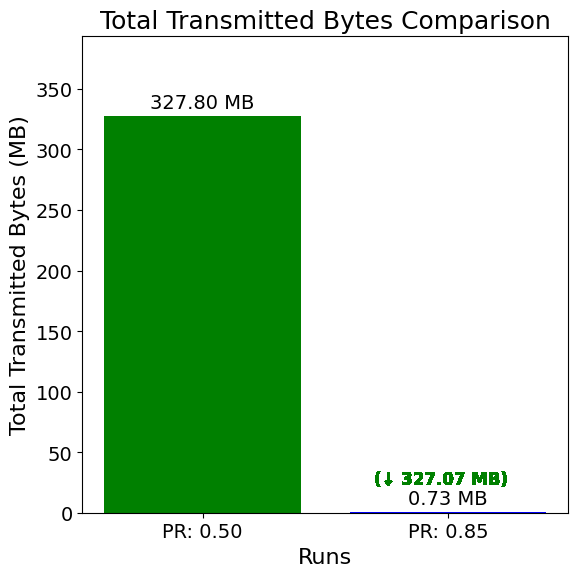

In [171]:
# Assuming 'total_bytes_mb', 'runs', 'colors', 'DO_SAVE', and 'save_dir' are already defined

max_value = max(total_bytes_mb)

# Increase global font size
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6, 6))

bars = ax.bar(list(plot_names.values()), [0, 0], color=[colors[run] for run in runs])  # Start bars at height 0
ax.set_xlabel('Runs', fontsize=16)
ax.set_ylabel('Total Transmitted Bytes (MB)', fontsize=16)
ax.set_title('Total Transmitted Bytes Comparison', fontsize=18)
ax.set_ylim(0, max(total_bytes_mb)*1.2)  # Set y-axis limit to accommodate text

def animate(frame):
    for idx, bar in enumerate(bars):
        target_height = total_bytes_mb[idx]
        height = min(frame, target_height)
        bar.set_height(height)
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Remove any existing text
        if hasattr(bar, 'value_text'):
            bar.value_text.remove()
        # Value label
        bar.value_text = ax.text(x, y + max_value * 0.01, f'{height:.2f} MB', ha='center', va='bottom', fontsize=14)
        # For run2, add difference
        if runs[idx] == 'run2' and frame >= target_height:
            total_bytes_run1 = total_bytes['run1']
            total_bytes_run2 = total_bytes['run2']
            difference_mb = (total_bytes_run2 - total_bytes_run1) / 1e6
            if difference_mb < 0:
                arrow = '↓'
                color = 'green'
            elif difference_mb > 0:
                arrow = '↑'
                color = 'red'
            else:
                arrow = ''
                color = 'black'
            difference_text = f"({arrow} {abs(difference_mb):.2f} MB)"
            ax.text(x-0.3, y + max_value * 0.06, difference_text,
                    ha='left', va='bottom', color=color, fontweight='bold', fontsize=12)

ani = FuncAnimation(
    fig,
    animate,
    frames=int(max_value) + 10,
    interval=50,
    repeat=False
)

plt.tight_layout()
if DO_SAVE:
    ani.save(os.path.join(save_dir, 'total_transmitted_bytes_comparison_animation.mp4'),
             writer='ffmpeg', fps=25)
plt.show()


3315.6814193353057
777.091140858829


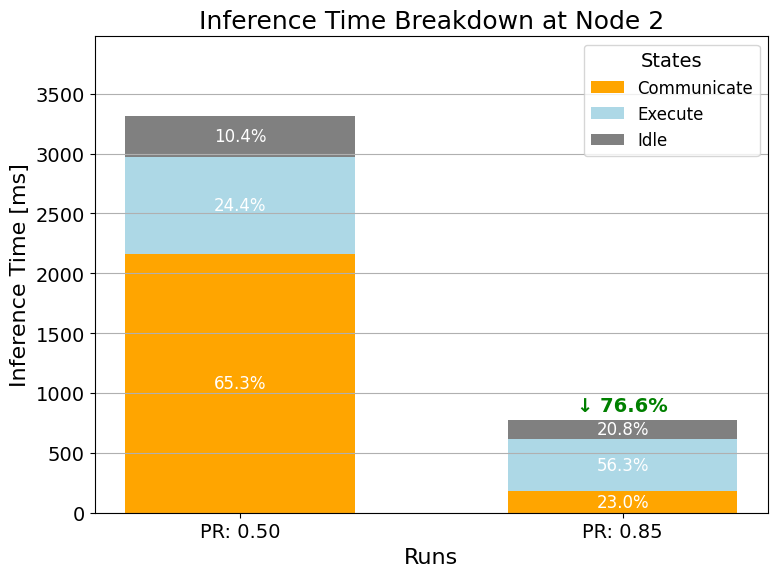

In [172]:
# Assuming 'dataframes' is a dictionary containing DataFrames for both runs
# Example:
# dataframes = {'run1': block_event_df_run1, 'run2': block_event_df_run2}

runs = ['run1', 'run2']
colors = {'run1': 'blue', 'run2': 'orange'}  # Colors for the runs

# Define the new state names and colors
state_types = ['Communicate', 'Execute', 'Idle']
state_colors = {
    'Communicate': 'orange',  # Color for 'Communicate' state
    'Execute': 'lightblue',
    'Idle': 'gray',
}

DO_SAVE = True  # Set to True if you want to save the plots

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Node to analyze
node = 2

# Collect execution times for each state and run
execution_times = {}
for run in runs:
    df = dataframes[run]
    df_node = df[df['node'] == node]
    total_time = df_node.loc[df_node['type'].isin(['idle', 'execute', 'total_send']), 'dur'].sum()
    print(total_time)
    state_times = {}
    # Merge 'receive' and 'total_send' into 'Communicate'
    communicate_time = df_node.loc[df_node['type'].isin(['total_send']), 'dur'].sum() # receive
    state_times['Communicate'] = communicate_time
    # Get 'Execute' and 'Idle' times
    for state in ['Execute', 'Idle']:
        state_time = df_node.loc[df_node['type'] == state.lower(), 'dur'].sum()
        state_times[state] = state_time
    execution_times[run] = {'total_time': total_time, 'state_times': state_times}

# Prepare data for animation
bar_width = 0.6
x = np.arange(len(runs))  # Positions for the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Increase font sizes
plt.rcParams.update({'font.size': 14})
ax.set_xlabel('Runs', fontsize=16)
ax.set_ylabel('Inference Time [ms]', fontsize=16)
ax.set_title(f'Inference Time Breakdown at Node {node}', fontsize=18)

# Add horizontal grid
ax.grid(True, axis='y')

# Initialize empty bars for each state
bars_dict = {}
state_values_dict = {}
for state in state_types:
    state_values = [execution_times[run]['state_times'][state] for run in runs]
    state_values_dict[state] = state_values
    bars = ax.bar(
        x,
        [0] * len(runs),
        bottom=[0] * len(runs),
        width=bar_width,
        color=state_colors[state],
        label=state
    )
    bars_dict[state] = bars

ax.set_xticks(x)
ax.set_xticklabels(list(plot_names.values()))
ax.legend(title='States', fontsize=12, title_fontsize=14)
ax.set_ylim(0, sum([max(state_values_dict[state]) for state in state_types]) * 1.2)  # Adjust y-axis limit

# Prepare the sequence of states to animate
state_sequence = state_types  # ['Communicate', 'Execute', 'Idle']
frames_per_state = 20  # Adjust to control the speed (fewer frames for faster animation)
total_frames = frames_per_state * len(state_sequence)

def animate(frame):
    current_state_idx = frame // frames_per_state
    progress_in_state = (frame % frames_per_state + 1) / frames_per_state
    bottoms = np.zeros(len(runs))
    total_times = [execution_times[run]['total_time'] for run in runs]
    for s_idx, state in enumerate(state_sequence):
        state_values = state_values_dict[state]
        bars = bars_dict[state]
        if s_idx < current_state_idx:
            # Previous states are fully loaded
            for idx, bar in enumerate(bars):
                if frame == 0:  # Special case for the first frame
                    bar.set_height(0)
                else:
                    bar.set_height(state_values[idx])
                bar.set_y(bottoms[idx])
                # Add percentage label if applicable
                percent = (state_values[idx] / total_times[idx]) * 100 if total_times[idx] > 0 else 0
                if percent > 5:
                    if not hasattr(bar, 'label_text'):
                        bar.label_text = ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            bottoms[idx] + state_values[idx] / 2,
                            f'{percent:.1f}%',
                            ha='center',
                            va='center',
                            color='white',
                            fontsize=12
                        )
            bottoms += state_values
        elif s_idx == current_state_idx:
            # Current state is loading
            for idx, bar in enumerate(bars):
                height = state_values[idx] * progress_in_state
                if frame == 0:  # Special case for the first frame
                    bar.set_height(0)
                else:
                    bar.set_height(height)
                bar.set_y(bottoms[idx])
                # Calculate current percentage
                current_total = bottoms[idx] + height
                percent = (height / total_times[idx]) * 100 if total_times[idx] > 0 else 0
                if percent > 5:
                    if hasattr(bar, 'label_text'):
                        bar.label_text.remove()
                    bar.label_text = ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bottoms[idx] + height / 2,
                        f'{percent:.1f}%',
                        ha='center',
                        va='center',
                        color='white',
                        fontsize=12
                    )
                elif hasattr(bar, 'label_text'):
                    bar.label_text.remove()
            # Update bottoms with the partial height
            temp_bottoms = [bottoms[idx] + state_values[idx] * progress_in_state for idx in range(len(runs))]
        else:
            # Next states are empty
            for idx, bar in enumerate(bars):
                bar.set_height(0)
                bar.set_y(bottoms[idx])
                if hasattr(bar, 'label_text'):
                    bar.label_text.remove()
        # No need to update bottoms here
    # After all states are loaded, add the percentage change text
    if frame == total_frames - 1:
        # Calculate percentage reduction for run2 compared to run1
        total_time_run1 = execution_times['run1']['total_time']
        total_time_run2 = execution_times['run2']['total_time']
        if total_time_run1 != 0:
            percentage_change_time = ((total_time_run2 - total_time_run1) / total_time_run1) * 100
        else:
            percentage_change_time = 0  # Avoid division by zero

        # Determine arrow and color
        if percentage_change_time < 0:
            arrow = '↓'
            color = 'green'  # Decrease is positive for execution time reduction
        elif percentage_change_time > 0:
            arrow = '↑'
            color = 'red'    # Increase is negative for execution time
        else:
            arrow = ''
            color = 'black'

        # Format percentage change
        percentage_change_text = f"{arrow} {abs(percentage_change_time):.1f}%"

        # Add the text on top of the second bar
        x_pos = x[1]  # Position of the second bar
        y_pos = sum([state_values_dict[state][1] for state in state_sequence]) + \
                max(sum([state_values_dict[state][1] for state in state_sequence]) * 0.05, 10)
        ax.text(
            x_pos,
            y_pos,
            percentage_change_text,
            ha='center',
            va='bottom',
            color=color,
            fontweight='bold',
            fontsize=14
        )

ani = FuncAnimation(
    fig,
    animate,
    frames=total_frames,
    interval=20,  # Adjust interval to control speed (smaller is faster)
    repeat=False
)

plt.tight_layout()
if DO_SAVE:
    ani.save(os.path.join(save_dir, 'execution_time_breakdown_node1_animation.mp4'),
             writer='ffmpeg', fps=20)

plt.show()